In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import glob
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# List of 50 stock symbols
stocks = [
    "AAPL","MSFT","GOOGL","AMZN","TSLA","META","NVDA","JPM","V","UNH",
    "HD","PG","DIS","MA","BAC","NFLX","ADBE","PYPL","CMCSA","XOM",
    "PFE","KO","INTC","CSCO","NKE","MRK","PEP","ABBV","ABT","CRM",
    "ORCL","T","VZ","CVX","MCD","WMT","DHR","ACN","LLY","AVGO",
    "QCOM","TXN","NEE","COST","TMUS","IBM","SBUX","MDT","HON","AMD"
]

# Folders
processed_folder = "../data/processed"
predictions_folder = "../data/predictions/GRU_predictions"
predictions_folder_recursive = "../data/predictions/GRU_recursive"
plots_folder = "../plots/GRU_plots"
plots_folder_recursive = "../data/plots/GRU_recursive"
os.makedirs(predictions_folder, exist_ok=True)
os.makedirs(predictions_folder_recursive, exist_ok=True)
os.makedirs(plots_folder, exist_ok=True)

processed_stocks = []
skipped_stocks = []

In [ ]:
def create_sequences(data, seq_len):
    X_list, y_list = [], []
    for i in range(len(data) - seq_len):
        X_list.append(data[i:i+seq_len])
        y_list.append(data[i+seq_len])
    return np.array(X_list), np.array(y_list)

In [ ]:
for symbol in stocks:
    print(f"\n--- Processing {symbol} ---")
    # Find latest processed CSV for the symbol
    files = glob.glob(f"{processed_folder}/{symbol}_processed*.csv")
    if files:
        processed_file = sorted(files)[-1]  # pick the latest file
    else:
        print(f"Processed file for {symbol} not found. Skipping.")
        skipped_stocks.append(symbol)
        continue

    ######## 
    SEQ_LEN = 30  
    EPOCHS = 100 
    BATCH_SIZE = 32

    data = pd.read_csv(processed_file, parse_dates=['Price'])
    prices = data["Close"].values.reshape(-1, 1)

    ######## Test and train stuff

    train_size = int(len(prices) * 0.8)
    prices_train = prices[:train_size]
    prices_test = prices[train_size:]

    scaler = MinMaxScaler()
    
    prices_train_scaled = scaler.fit_transform(prices_train)
    prices_test_scaled = scaler.transform(prices_test)

    ######## Create sequences separately for train and test
    X_train, y_train = create_sequences(prices_train_scaled, SEQ_LEN)
    X_test, y_test = create_sequences(prices_test_scaled, SEQ_LEN)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

    ######## Initialize model

    GRU = nn.GRU(1, 64, 2, batch_first=True)
    connection_density = nn.Linear(64, 1)

    criterion = nn.MSELoss()

    #Adam, AdamW, RMSprop, Adamax, SGD... << optimizers
    optimizer = torch.optim.AdamW(list(GRU.parameters()) + list(connection_density.parameters()), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    # n_jobs = -1?
    # Use GridSearch?

    ######## Looping epoch 

    for epoch in range(EPOCHS):
        GRU.train()
        connection_density.train()

        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out, _ = GRU(batch_X)
            preds = connection_density(out[:, -1, :])

            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {avg_loss:.6f}")

    ######## Evaluation

    GRU.eval()
    connection_density.eval()

    ########## Prediction here

    out_test, _ = GRU(X_test)
    pred_test = connection_density(out_test[:, -1, :]).detach().numpy()

    pred_test = scaler.inverse_transform(pred_test)
    actual_test = scaler.inverse_transform(y_test.numpy())

    ####### Recursive here

    FUTURE_DAYS = 30
    NOISE_FACTOR = 0.1

    current_volatility = data["Close"].pct_change().std()
    sequence = X_test[-1].view(1, SEQ_LEN, 1)
    forecast_data = []

    with torch.no_grad():
        for i in range(FUTURE_DAYS):
            out, _ = GRU(sequence)
            pred_scaled = connection_density(out[:, -1, :]) # Shape: 1, 1
            price_unscaled = scaler.inverse_transform(pred_scaled.cpu().numpy())[0, 0]
            
            noise = np.random.normal(0, current_volatility * NOISE_FACTOR)
            noisy_price = price_unscaled * (1 + noise)

            forecast_data.append(noisy_price)
            
            noisy_scaled = scaler.transform([[noisy_price]])[0, 0]
            new_step = torch.tensor([[[noisy_scaled]]], dtype=torch.float32)

            sequence = torch.cat((sequence[:, 1:, :], new_step), dim=1)

    final_forecast = np.array(forecast_data)

    last_date = data.index[-1]
    future_dates = pd.bdate_range(start=last_date, periods=FUTURE_DAYS + 1)[1:]

    ######## Metrics here

    mse_gru = mean_squared_error(actual_test, pred_test)
    rmse_gru = np.sqrt(mse_gru)
    r2_gru = r2_score(actual_test, pred_test)
    mae_gru = mean_absolute_error(actual_test, pred_test)
    mape_gru = np.mean(np.abs((actual_test - pred_test) / np.where(actual_test==0, 1e-8, actual_test))) * 100

    print("\nMetrics:")
    print("Close >> RMSE: $", "%.4f" % rmse_gru, "R2:", "%.4f" % r2_gru, "MAE: $", "%.4f" % mae_gru)

    ######### Plots here + save plot

    plt.figure(figsize=(10, 5))
    plt.plot(actual_test, label="Actual Price")
    plt.plot(pred_test, label="Predicted Price")
    plt.title(f"{symbol} GRU Stock Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.legend()
    plot_file = os.path.join(plots_folder, f"{symbol}_gru_plot.png")
    plt.savefig(plot_file)
    plt.show()

    ########### Save metrics

    metrics_df = pd.DataFrame([{
            'Symbol': symbol,
            'MSE': mse_gru,
            'RMSE': rmse_gru,
            'MAPE': mape_gru,
            'R2': r2_gru
        }])
    metrics_df.to_csv(os.path.join(predictions_folder, f"{symbol}_metrics.csv"), index=False)

    ########### Save predictions

    original_dates = data['Price'].iloc[SEQ_LEN:]
    test_dates = original_dates.iloc[train_size:].reset_index(drop=True)

    gru_prediction = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close': actual_test.flatten(),
    'Predicted_Close': pred_test.flatten()
    })
    
    predictions_file = os.path.join(predictions_folder, f"{symbol}_predictions.csv")
    gru_prediction.to_csv(predictions_file)

    ########### Forecast save
    forecast_df = pd.DataFrame({
            "Date": future_dates,
            "Predicted_Close": final_forecast
        })
    forecast_csv_path = os.path.join(predictions_folder_recursive, f"{symbol}_recursive_forecast.csv")
    forecast_df.to_csv(forecast_csv_path, index=False)

    ########### Append stocks

    processed_stocks.append(symbol)

print("\nGRU processing complete.")
print("Processed stocks:", processed_stocks)
print("Skipped stocks:", skipped_stocks)



--- Processing AAPL ---
Epoch 0 | Loss: 0.031382
Epoch 10 | Loss: 0.006001
Epoch 20 | Loss: 0.005789
Epoch 30 | Loss: 0.005719
Epoch 40 | Loss: 0.005643
Epoch 50 | Loss: 0.005621
Epoch 60 | Loss: 0.005660
Epoch 70 | Loss: 0.005598
Epoch 80 | Loss: 0.005706
Epoch 90 | Loss: 0.005713

Metrics (on Prices):
Close >> RMSE: $ 2.5713 R2: 0.9900 MAE: $ 1.8863 MAPE: 0.99%


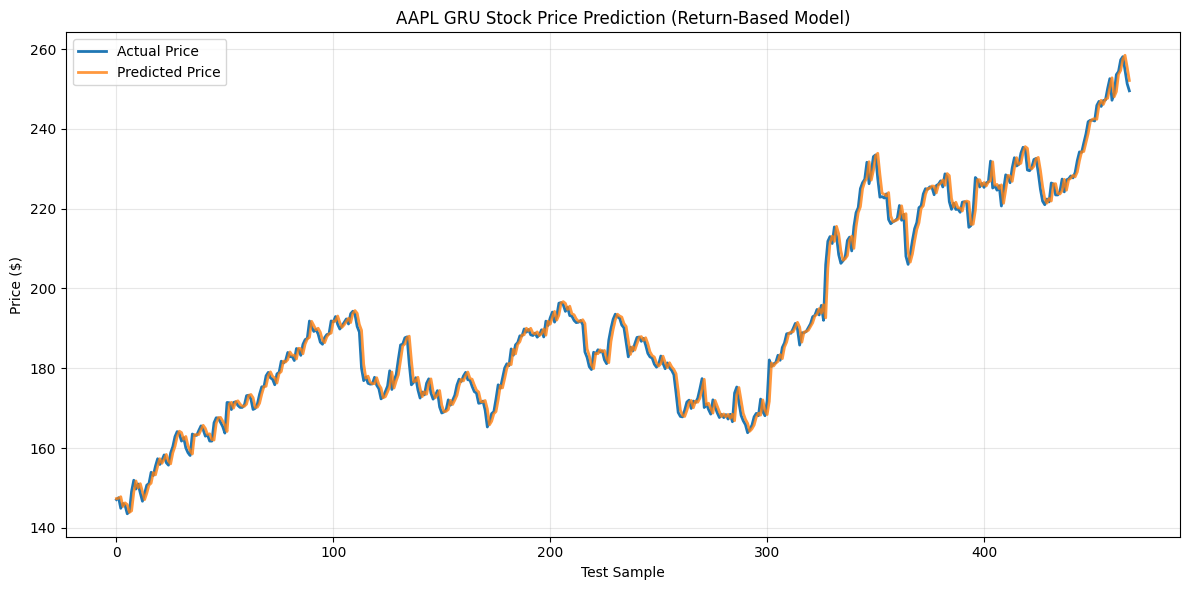


Forecast Summary:
Current Price: $249.53
Day 1 Forecast: $250.38 (Return: 0.0034)
Day 30 Forecast: $257.30
Total Expected Change: 3.11%

--- Processing MSFT ---
Epoch 0 | Loss: 0.042028
Epoch 10 | Loss: 0.003833
Epoch 20 | Loss: 0.003769
Epoch 30 | Loss: 0.003717
Epoch 40 | Loss: 0.003648
Epoch 50 | Loss: 0.003710
Epoch 60 | Loss: 0.003578
Epoch 70 | Loss: 0.003596
Epoch 80 | Loss: 0.003596
Epoch 90 | Loss: 0.003560

Metrics (on Prices):
Close >> RMSE: $ 4.9980 R2: 0.9918 MAE: $ 3.7896 MAPE: 1.04%


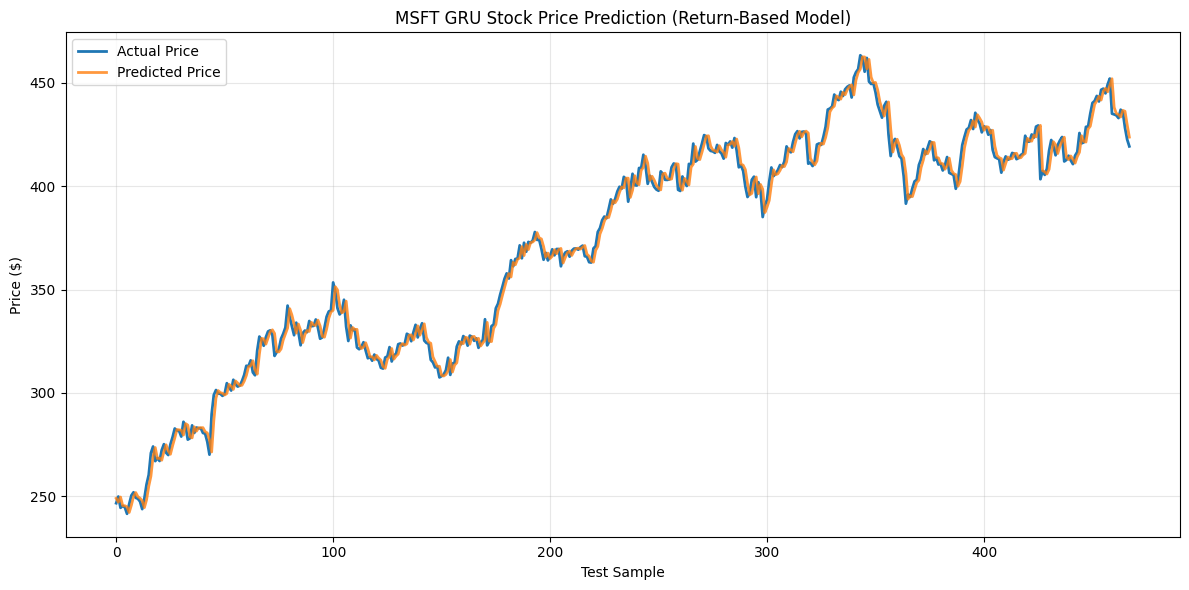


Forecast Summary:
Current Price: $419.20
Day 1 Forecast: $420.27 (Return: 0.0026)
Day 30 Forecast: $426.49
Total Expected Change: 1.74%

--- Processing GOOGL ---
Epoch 0 | Loss: 0.018585
Epoch 10 | Loss: 0.004286
Epoch 20 | Loss: 0.004305
Epoch 30 | Loss: 0.004458
Epoch 40 | Loss: 0.004195
Epoch 50 | Loss: 0.004286
Epoch 60 | Loss: 0.004211
Epoch 70 | Loss: 0.004234
Epoch 80 | Loss: 0.004234
Epoch 90 | Loss: 0.004183

Metrics (on Prices):
Close >> RMSE: $ 2.5621 R2: 0.9897 MAE: $ 1.8167 MAPE: 1.27%


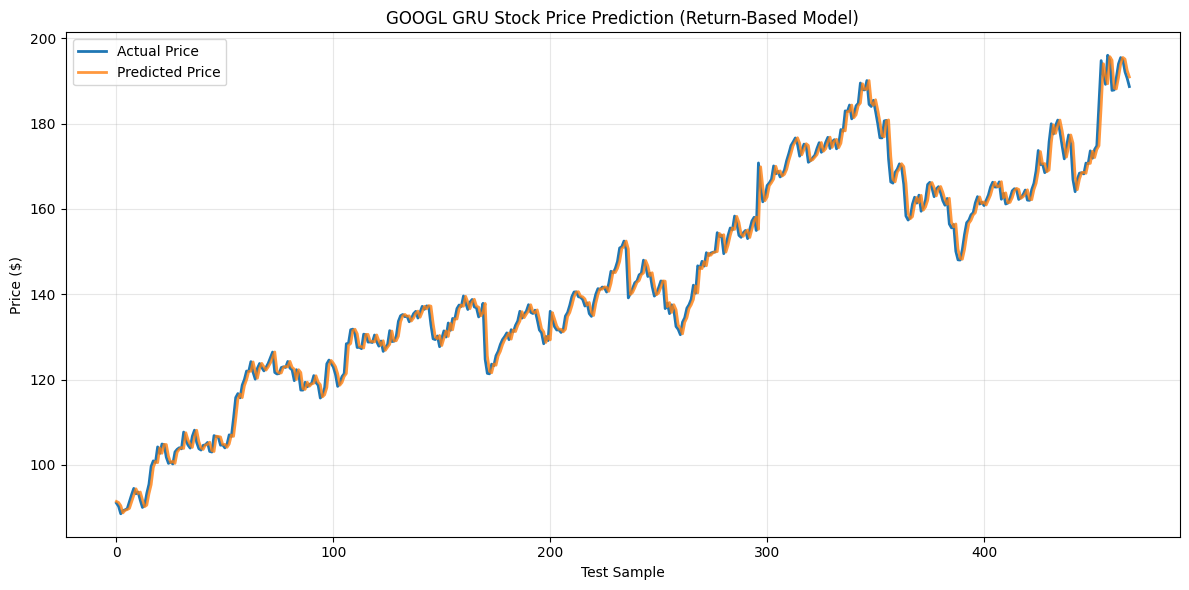


Forecast Summary:
Current Price: $188.68
Day 1 Forecast: $188.98 (Return: 0.0016)
Day 30 Forecast: $192.85
Total Expected Change: 2.21%

--- Processing AMZN ---
Epoch 0 | Loss: 0.026292
Epoch 10 | Loss: 0.005740
Epoch 20 | Loss: 0.005508
Epoch 30 | Loss: 0.005472
Epoch 40 | Loss: 0.005460
Epoch 50 | Loss: 0.005483
Epoch 60 | Loss: 0.005500
Epoch 70 | Loss: 0.005394
Epoch 80 | Loss: 0.005368
Epoch 90 | Loss: 0.005478

Metrics (on Prices):
Close >> RMSE: $ 2.8842 R2: 0.9929 MAE: $ 2.1305 MAPE: 1.37%


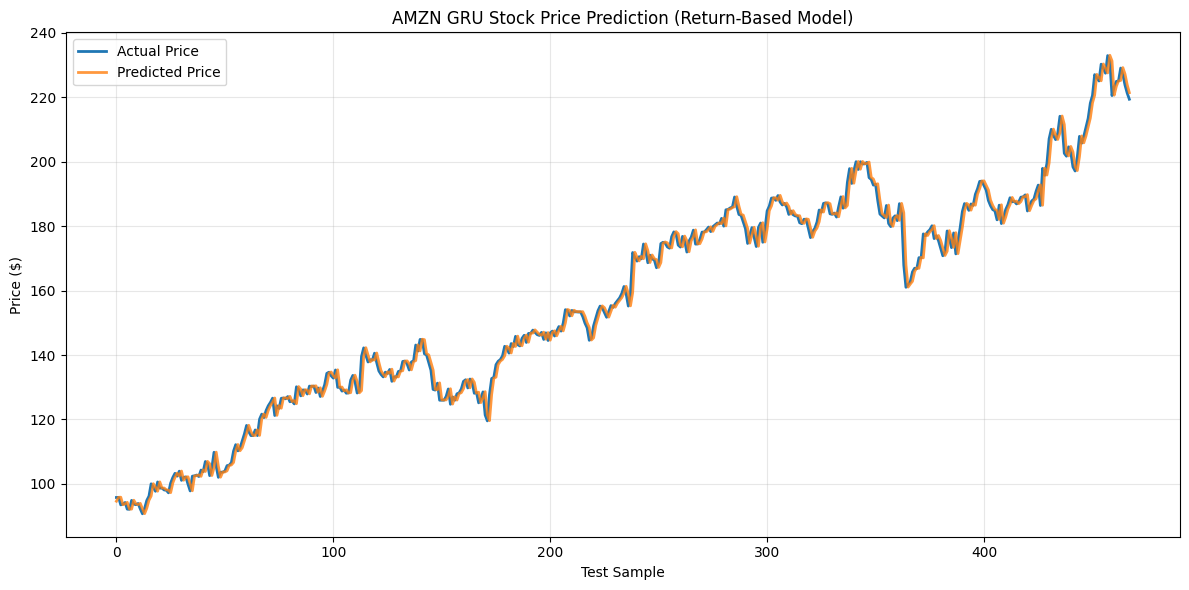


Forecast Summary:
Current Price: $219.39
Day 1 Forecast: $219.70 (Return: 0.0014)
Day 30 Forecast: $222.56
Total Expected Change: 1.44%

--- Processing TSLA ---
Epoch 0 | Loss: 0.039347
Epoch 10 | Loss: 0.007602
Epoch 20 | Loss: 0.007662
Epoch 30 | Loss: 0.007598
Epoch 40 | Loss: 0.007637
Epoch 50 | Loss: 0.007512
Epoch 60 | Loss: 0.007583
Epoch 70 | Loss: 0.007418
Epoch 80 | Loss: 0.007490
Epoch 90 | Loss: 0.007541

Metrics (on Prices):
Close >> RMSE: $ 8.7026 R2: 0.9769 MAE: $ 6.0740 MAPE: 2.60%


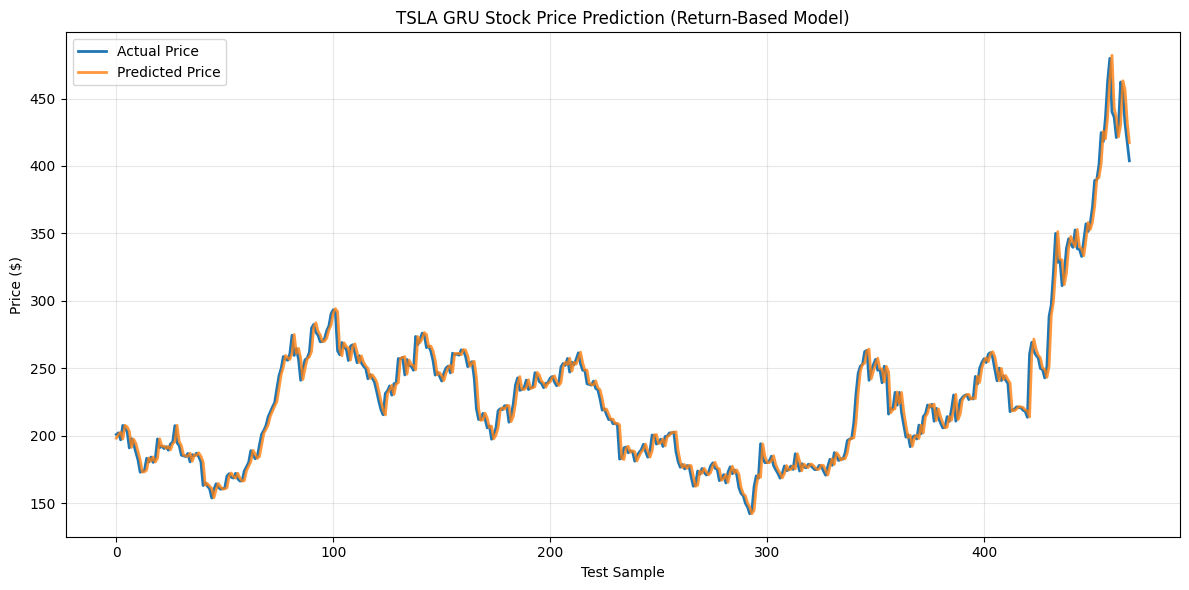


Forecast Summary:
Current Price: $403.84
Day 1 Forecast: $403.11 (Return: -0.0018)
Day 30 Forecast: $415.45
Total Expected Change: 2.87%

--- Processing META ---
Epoch 0 | Loss: 0.060670
Epoch 10 | Loss: 0.002715
Epoch 20 | Loss: 0.002778
Epoch 30 | Loss: 0.002739
Epoch 40 | Loss: 0.002696
Epoch 50 | Loss: 0.002672
Epoch 60 | Loss: 0.002698
Epoch 70 | Loss: 0.002683
Epoch 80 | Loss: 0.002696
Epoch 90 | Loss: 0.002666

Metrics (on Prices):
Close >> RMSE: $ 8.7560 R2: 0.9953 MAE: $ 5.8268 MAPE: 1.47%


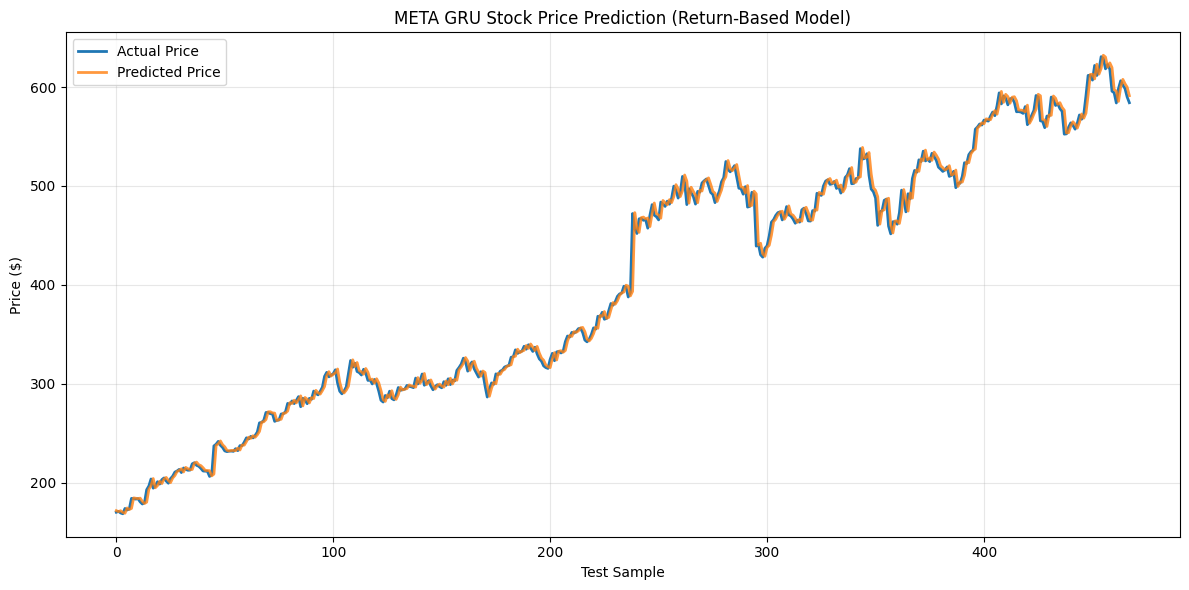


Forecast Summary:
Current Price: $584.15
Day 1 Forecast: $585.23 (Return: 0.0019)
Day 30 Forecast: $622.65
Total Expected Change: 6.59%

--- Processing NVDA ---
Epoch 0 | Loss: 0.012464
Epoch 10 | Loss: 0.004466
Epoch 20 | Loss: 0.004233
Epoch 30 | Loss: 0.004263
Epoch 40 | Loss: 0.004283
Epoch 50 | Loss: 0.004156
Epoch 60 | Loss: 0.004181
Epoch 70 | Loss: 0.004193
Epoch 80 | Loss: 0.004203
Epoch 90 | Loss: 0.004158

Metrics (on Prices):
Close >> RMSE: $ 2.6590 R2: 0.9956 MAE: $ 1.7664 MAPE: 2.23%


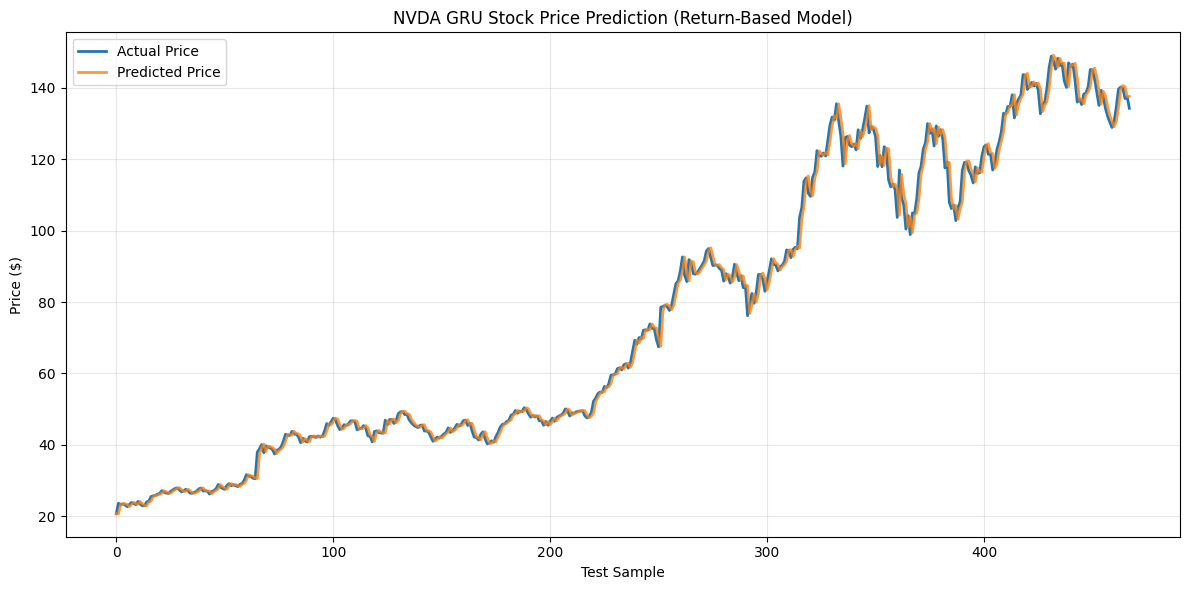


Forecast Summary:
Current Price: $134.26
Day 1 Forecast: $134.32 (Return: 0.0004)
Day 30 Forecast: $139.35
Total Expected Change: 3.79%

--- Processing JPM ---
Epoch 0 | Loss: 0.017668
Epoch 10 | Loss: 0.003057
Epoch 20 | Loss: 0.003628
Epoch 30 | Loss: 0.003041
Epoch 40 | Loss: 0.002982
Epoch 50 | Loss: 0.003016
Epoch 60 | Loss: 0.002977
Epoch 70 | Loss: 0.002957
Epoch 80 | Loss: 0.003063
Epoch 90 | Loss: 0.003010

Metrics (on Prices):
Close >> RMSE: $ 2.5223 R2: 0.9950 MAE: $ 1.6133 MAPE: 0.94%


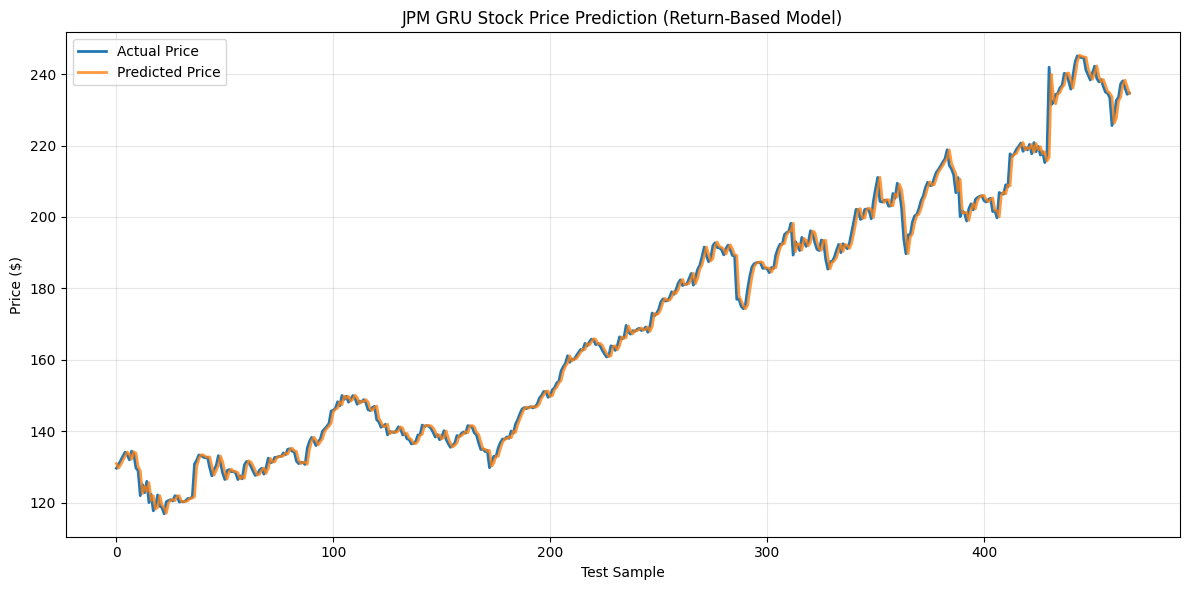


Forecast Summary:
Current Price: $234.74
Day 1 Forecast: $234.84 (Return: 0.0004)
Day 30 Forecast: $237.22
Total Expected Change: 1.06%

--- Processing V ---
Epoch 0 | Loss: 0.040135
Epoch 10 | Loss: 0.003643
Epoch 20 | Loss: 0.003585
Epoch 30 | Loss: 0.003644
Epoch 40 | Loss: 0.003607
Epoch 50 | Loss: 0.003582
Epoch 60 | Loss: 0.003554
Epoch 70 | Loss: 0.003521
Epoch 80 | Loss: 0.003534
Epoch 90 | Loss: 0.003522

Metrics (on Prices):
Close >> RMSE: $ 2.6556 R2: 0.9901 MAE: $ 1.9385 MAPE: 0.76%


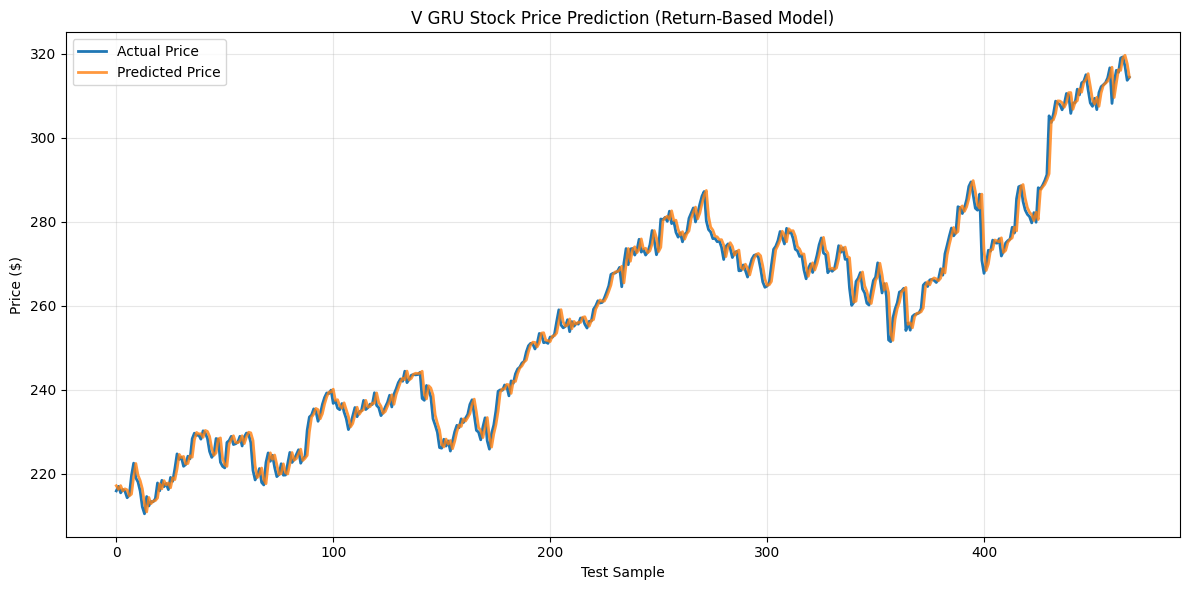


Forecast Summary:
Current Price: $314.43
Day 1 Forecast: $314.72 (Return: 0.0009)
Day 30 Forecast: $326.09
Total Expected Change: 3.71%

--- Processing UNH ---
Epoch 0 | Loss: 0.025266
Epoch 10 | Loss: 0.003120
Epoch 20 | Loss: 0.002967
Epoch 30 | Loss: 0.002977
Epoch 40 | Loss: 0.003783
Epoch 50 | Loss: 0.002947
Epoch 60 | Loss: 0.002896
Epoch 70 | Loss: 0.002928
Epoch 80 | Loss: 0.002911
Epoch 90 | Loss: 0.002871

Metrics (on Prices):
Close >> RMSE: $ 7.8478 R2: 0.9647 MAE: $ 5.2769 MAPE: 1.05%


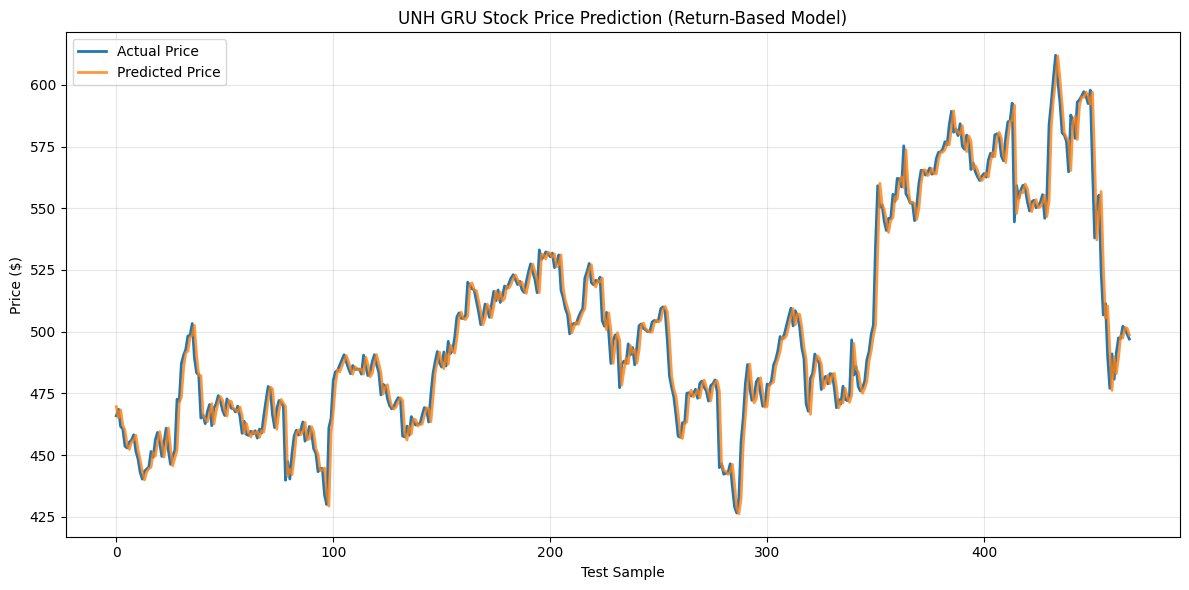


Forecast Summary:
Current Price: $497.02
Day 1 Forecast: $496.34 (Return: -0.0014)
Day 30 Forecast: $492.28
Total Expected Change: -0.95%

--- Processing HD ---
Epoch 0 | Loss: 0.029774
Epoch 10 | Loss: 0.002171
Epoch 20 | Loss: 0.002143
Epoch 30 | Loss: 0.002153
Epoch 40 | Loss: 0.002117
Epoch 50 | Loss: 0.002110
Epoch 60 | Loss: 0.002092
Epoch 70 | Loss: 0.002155
Epoch 80 | Loss: 0.002085
Epoch 90 | Loss: 0.002100

Metrics (on Prices):
Close >> RMSE: $ 4.2073 R2: 0.9901 MAE: $ 3.2363 MAPE: 0.99%


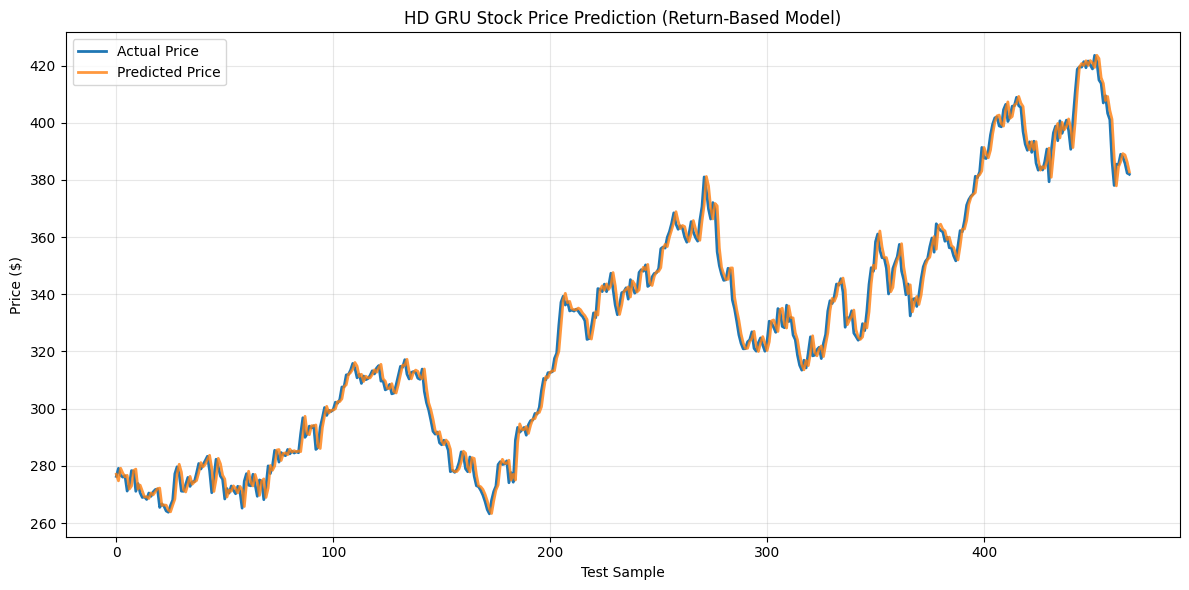


Forecast Summary:
Current Price: $381.98
Day 1 Forecast: $382.32 (Return: 0.0009)
Day 30 Forecast: $394.54
Total Expected Change: 3.29%

--- Processing PG ---
Epoch 0 | Loss: 0.017011
Epoch 10 | Loss: 0.003528
Epoch 20 | Loss: 0.003517
Epoch 30 | Loss: 0.003526
Epoch 40 | Loss: 0.004043
Epoch 50 | Loss: 0.003562
Epoch 60 | Loss: 0.003539
Epoch 70 | Loss: 0.003470
Epoch 80 | Loss: 0.003498
Epoch 90 | Loss: 0.003472

Metrics (on Prices):
Close >> RMSE: $ 1.4209 R2: 0.9844 MAE: $ 1.0300 MAPE: 0.68%


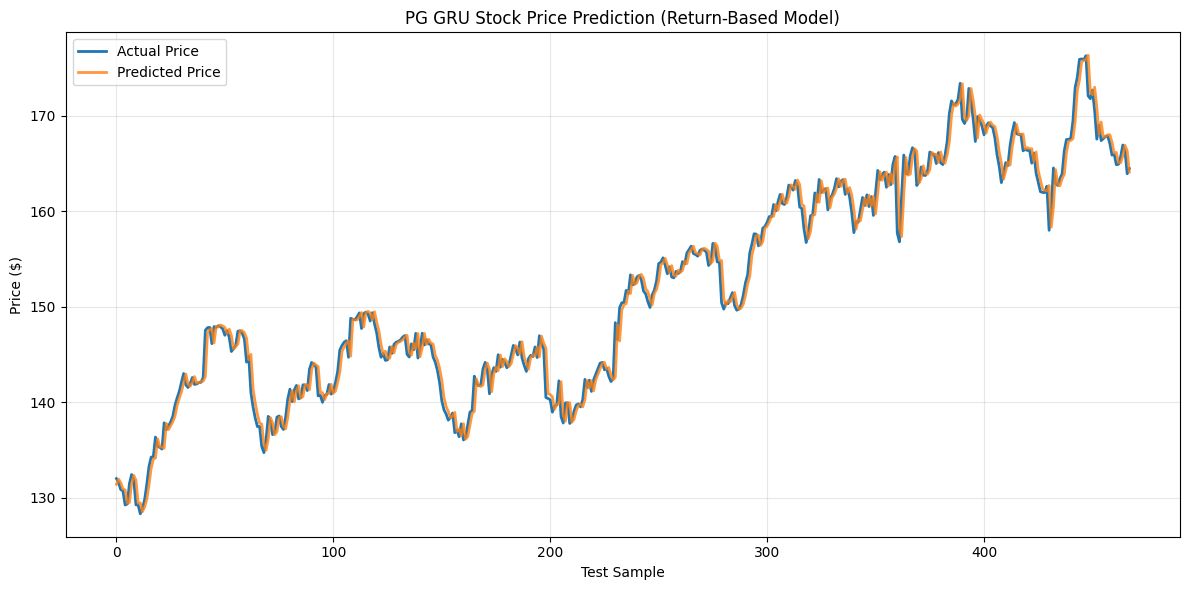


Forecast Summary:
Current Price: $164.48
Day 1 Forecast: $164.85 (Return: 0.0023)
Day 30 Forecast: $167.53
Total Expected Change: 1.86%

--- Processing DIS ---
Epoch 0 | Loss: 0.013952
Epoch 10 | Loss: 0.004216
Epoch 20 | Loss: 0.004241
Epoch 30 | Loss: 0.004325
Epoch 40 | Loss: 0.004149
Epoch 50 | Loss: 0.004179
Epoch 60 | Loss: 0.004207
Epoch 70 | Loss: 0.004172
Epoch 80 | Loss: 0.004190
Epoch 90 | Loss: 0.004153

Metrics (on Prices):
Close >> RMSE: $ 1.5794 R2: 0.9762 MAE: $ 1.0588 MAPE: 1.11%


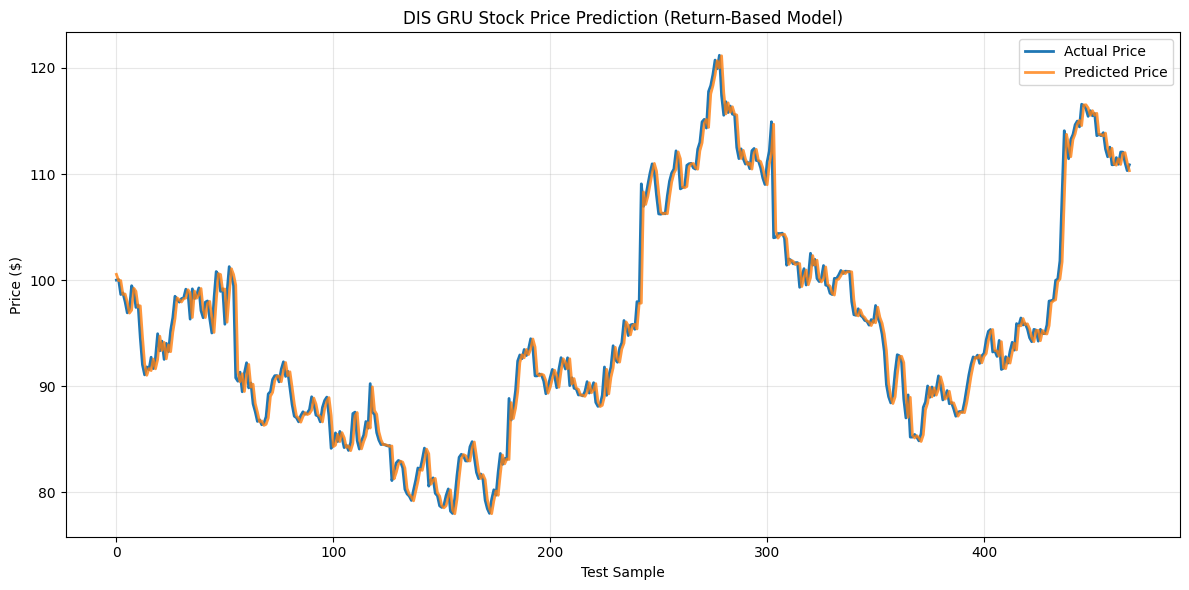


Forecast Summary:
Current Price: $110.88
Day 1 Forecast: $110.89 (Return: 0.0001)
Day 30 Forecast: $109.48
Total Expected Change: -1.26%

--- Processing MA ---
Epoch 0 | Loss: 0.017607
Epoch 10 | Loss: 0.004076
Epoch 20 | Loss: 0.003947
Epoch 30 | Loss: 0.003934
Epoch 40 | Loss: 0.003949
Epoch 50 | Loss: 0.004024
Epoch 60 | Loss: 0.003879
Epoch 70 | Loss: 0.003917
Epoch 80 | Loss: 0.003878
Epoch 90 | Loss: 0.004051

Metrics (on Prices):
Close >> RMSE: $ 4.4639 R2: 0.9924 MAE: $ 3.4029 MAPE: 0.80%


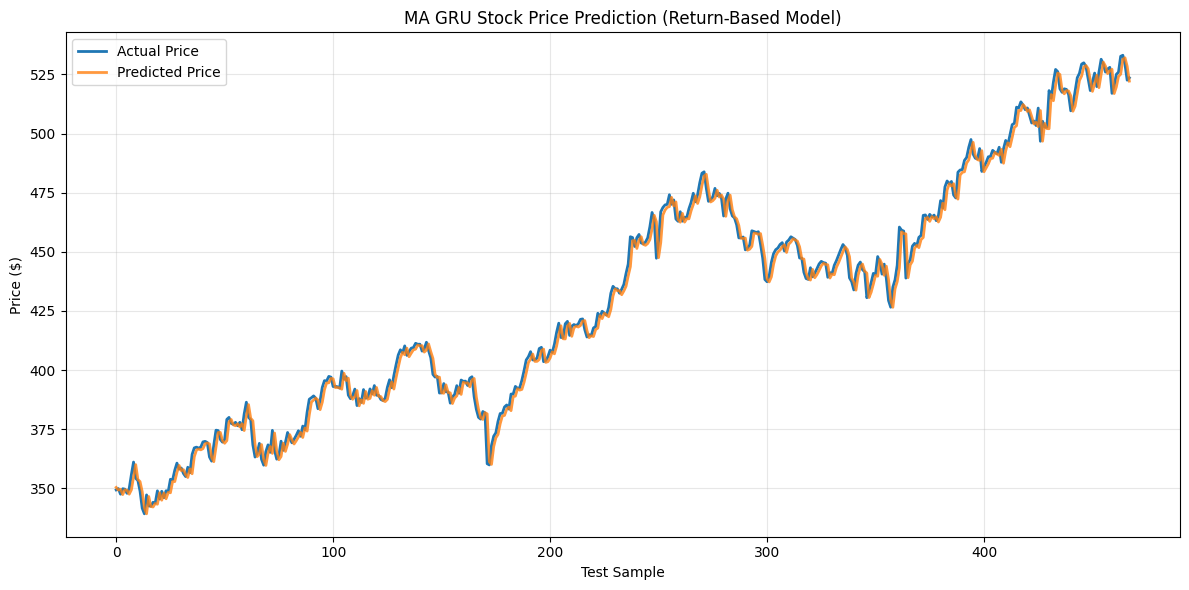


Forecast Summary:
Current Price: $523.56
Day 1 Forecast: $522.99 (Return: -0.0011)
Day 30 Forecast: $503.38
Total Expected Change: -3.85%

--- Processing BAC ---
Epoch 0 | Loss: 0.016818
Epoch 10 | Loss: 0.003885
Epoch 20 | Loss: 0.004158
Epoch 30 | Loss: 0.003836
Epoch 40 | Loss: 0.003922
Epoch 50 | Loss: 0.003805
Epoch 60 | Loss: 0.003828
Epoch 70 | Loss: 0.003874
Epoch 80 | Loss: 0.003797
Epoch 90 | Loss: 0.003775

Metrics (on Prices):
Close >> RMSE: $ 0.5252 R2: 0.9927 MAE: $ 0.3823 MAPE: 1.17%


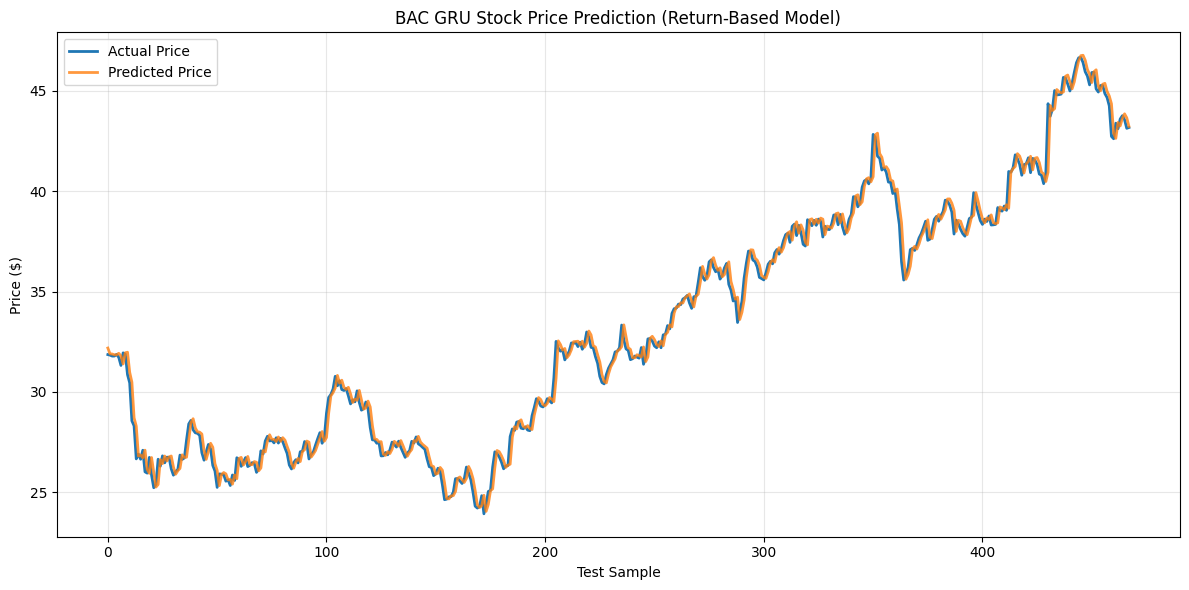


Forecast Summary:
Current Price: $43.18
Day 1 Forecast: $43.32 (Return: 0.0032)
Day 30 Forecast: $45.85
Total Expected Change: 6.18%

--- Processing NFLX ---
Epoch 0 | Loss: 0.074645
Epoch 10 | Loss: 0.002438
Epoch 20 | Loss: 0.002360
Epoch 30 | Loss: 0.002359
Epoch 40 | Loss: 0.002388
Epoch 50 | Loss: 0.002359
Epoch 60 | Loss: 0.002390
Epoch 70 | Loss: 0.002344
Epoch 80 | Loss: 0.002359
Epoch 90 | Loss: 0.002341

Metrics (on Prices):
Close >> RMSE: $ 10.9609 R2: 0.9955 MAE: $ 7.6171 MAPE: 1.44%


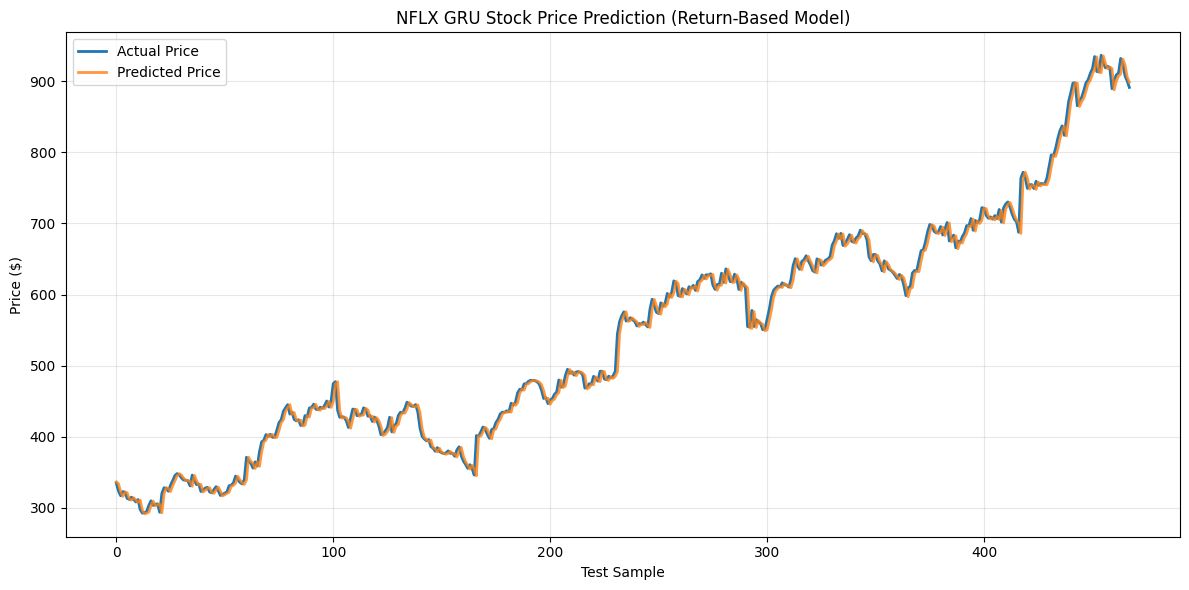


Forecast Summary:
Current Price: $891.32
Day 1 Forecast: $889.60 (Return: -0.0019)
Day 30 Forecast: $840.02
Total Expected Change: -5.76%

--- Processing ADBE ---
Epoch 0 | Loss: 0.027119
Epoch 10 | Loss: 0.003657
Epoch 20 | Loss: 0.003759
Epoch 30 | Loss: 0.003646
Epoch 40 | Loss: 0.003666
Epoch 50 | Loss: 0.003655
Epoch 60 | Loss: 0.003577
Epoch 70 | Loss: 0.003608
Epoch 80 | Loss: 0.003600
Epoch 90 | Loss: 0.003592

Metrics (on Prices):
Close >> RMSE: $ 11.1391 R2: 0.9776 MAE: $ 7.3373 MAPE: 1.47%


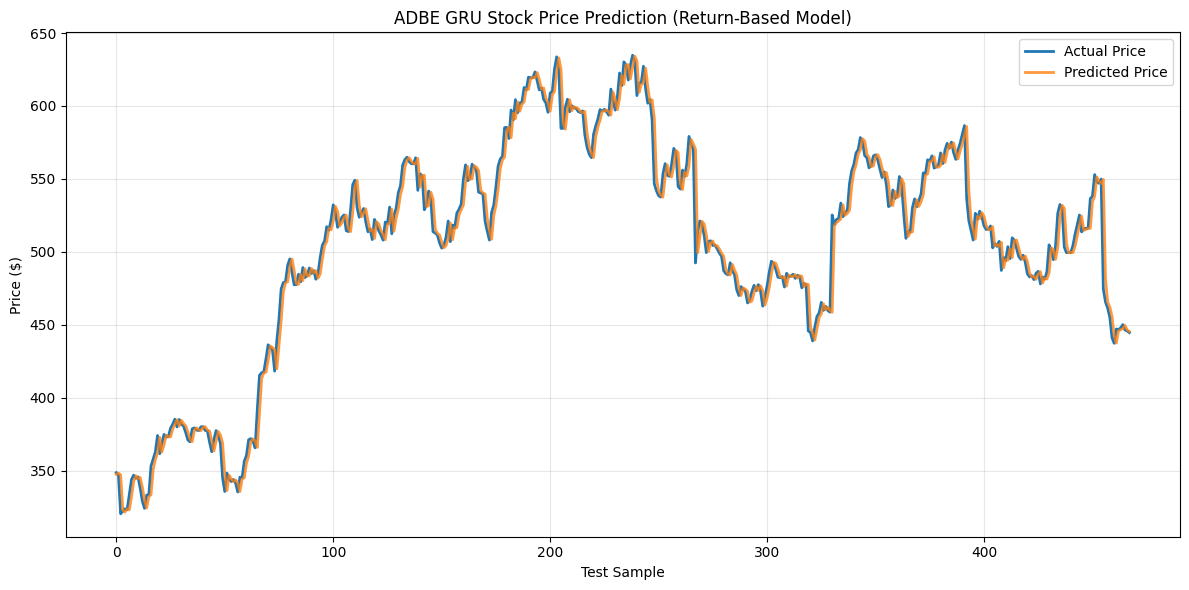


Forecast Summary:
Current Price: $444.68
Day 1 Forecast: $444.96 (Return: 0.0006)
Day 30 Forecast: $442.61
Total Expected Change: -0.47%

--- Processing PYPL ---
Epoch 0 | Loss: 0.063887
Epoch 10 | Loss: 0.003582
Epoch 20 | Loss: 0.003611
Epoch 30 | Loss: 0.003548
Epoch 40 | Loss: 0.003494
Epoch 50 | Loss: 0.003488
Epoch 60 | Loss: 0.003566
Epoch 70 | Loss: 0.003479
Epoch 80 | Loss: 0.003494
Epoch 90 | Loss: 0.003486

Metrics (on Prices):
Close >> RMSE: $ 1.5053 R2: 0.9726 MAE: $ 1.0657 MAPE: 1.62%


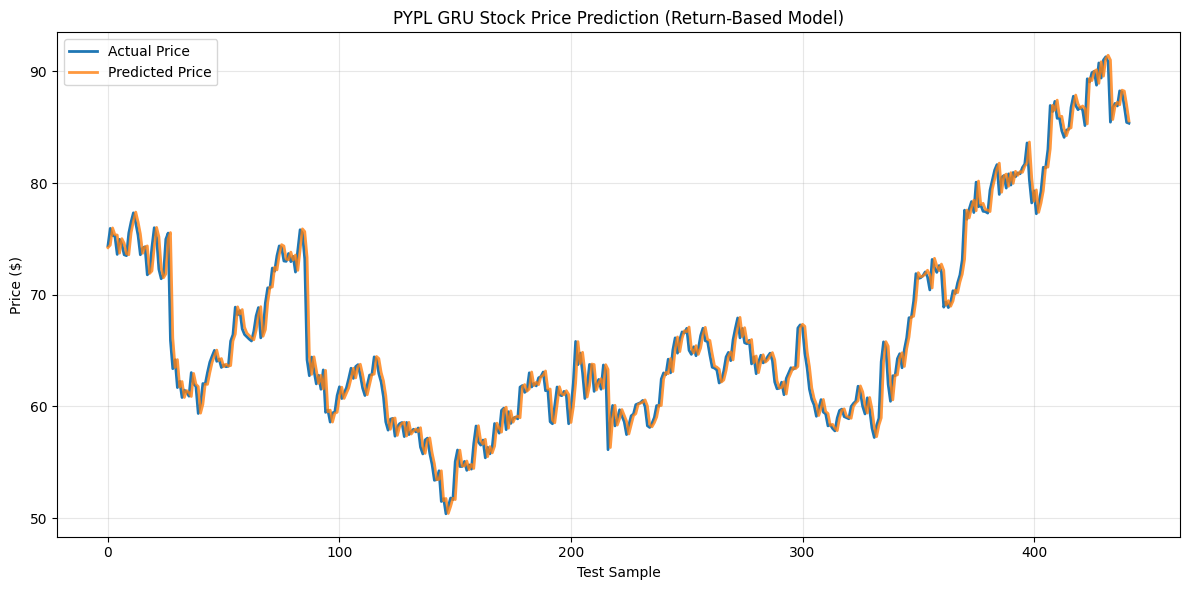


Forecast Summary:
Current Price: $85.35
Day 1 Forecast: $85.53 (Return: 0.0021)
Day 30 Forecast: $86.92
Total Expected Change: 1.84%

--- Processing CMCSA ---
Epoch 0 | Loss: 0.012521
Epoch 10 | Loss: 0.005757
Epoch 20 | Loss: 0.005919
Epoch 30 | Loss: 0.005787
Epoch 40 | Loss: 0.005633
Epoch 50 | Loss: 0.005641
Epoch 60 | Loss: 0.005647
Epoch 70 | Loss: 0.005608
Epoch 80 | Loss: 0.005632
Epoch 90 | Loss: 0.005584

Metrics (on Prices):
Close >> RMSE: $ 0.5921 R2: 0.9446 MAE: $ 0.4087 MAPE: 1.06%


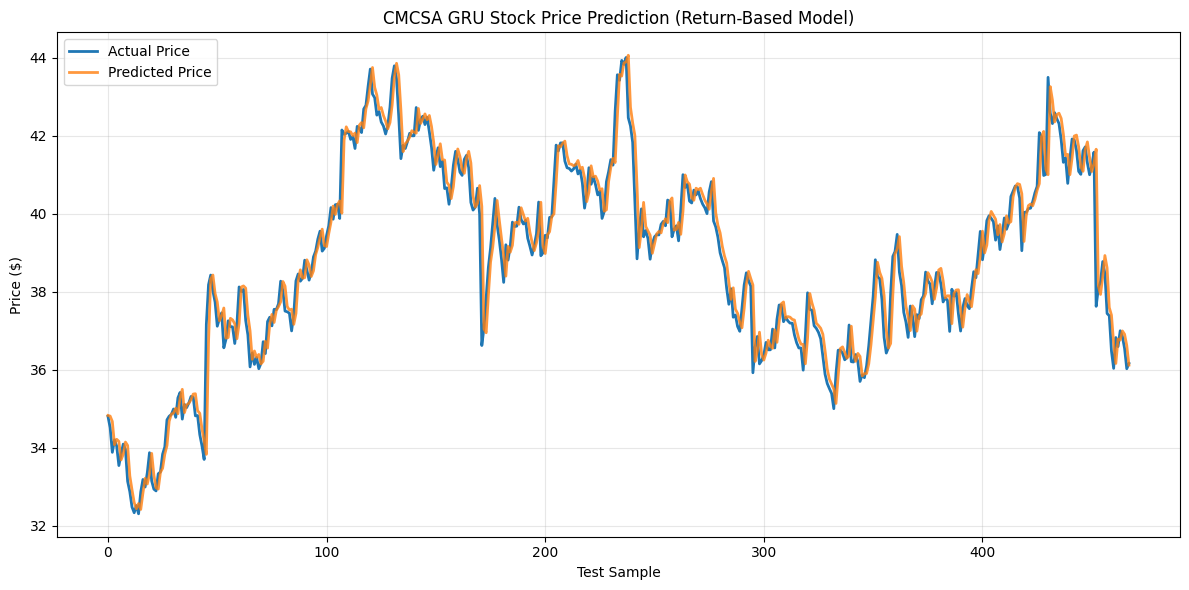


Forecast Summary:
Current Price: $36.16
Day 1 Forecast: $36.23 (Return: 0.0019)
Day 30 Forecast: $37.96
Total Expected Change: 4.96%

--- Processing XOM ---
Epoch 0 | Loss: 0.033425
Epoch 10 | Loss: 0.005686
Epoch 20 | Loss: 0.005511
Epoch 30 | Loss: 0.005412
Epoch 40 | Loss: 0.005433
Epoch 50 | Loss: 0.005534
Epoch 60 | Loss: 0.005465
Epoch 70 | Loss: 0.005469
Epoch 80 | Loss: 0.005469
Epoch 90 | Loss: 0.005410

Metrics (on Prices):
Close >> RMSE: $ 1.4263 R2: 0.9620 MAE: $ 1.0996 MAPE: 1.06%


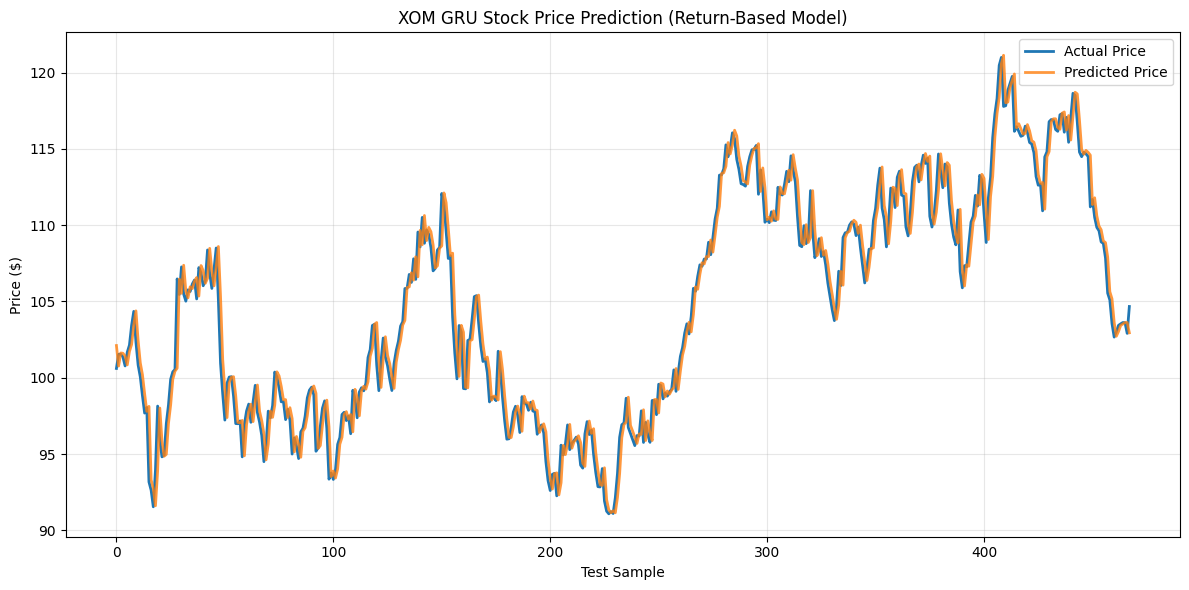


Forecast Summary:
Current Price: $104.67
Day 1 Forecast: $104.77 (Return: 0.0010)
Day 30 Forecast: $106.51
Total Expected Change: 1.75%

--- Processing PFE ---
Epoch 0 | Loss: 0.026190
Epoch 10 | Loss: 0.006567
Epoch 20 | Loss: 0.006604
Epoch 30 | Loss: 0.006430
Epoch 40 | Loss: 0.006402
Epoch 50 | Loss: 0.006498
Epoch 60 | Loss: 0.006436
Epoch 70 | Loss: 0.006422
Epoch 80 | Loss: 0.006388
Epoch 90 | Loss: 0.006787

Metrics (on Prices):
Close >> RMSE: $ 0.4066 R2: 0.9874 MAE: $ 0.3043 MAPE: 1.09%


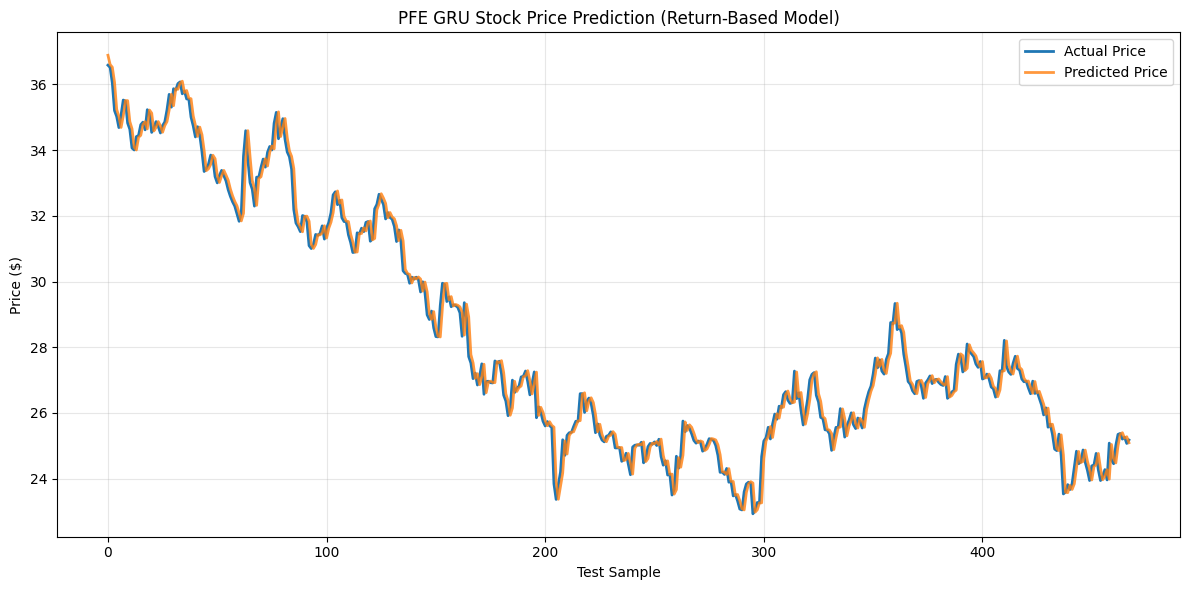


Forecast Summary:
Current Price: $25.18
Day 1 Forecast: $25.17 (Return: -0.0003)
Day 30 Forecast: $25.55
Total Expected Change: 1.48%

--- Processing KO ---
Epoch 0 | Loss: 0.025965
Epoch 10 | Loss: 0.005638
Epoch 20 | Loss: 0.005310
Epoch 30 | Loss: 0.005319
Epoch 40 | Loss: 0.005276
Epoch 50 | Loss: 0.005361
Epoch 60 | Loss: 0.005242
Epoch 70 | Loss: 0.005242
Epoch 80 | Loss: 0.005213
Epoch 90 | Loss: 0.005249

Metrics (on Prices):
Close >> RMSE: $ 0.4773 R2: 0.9887 MAE: $ 0.3585 MAPE: 0.61%


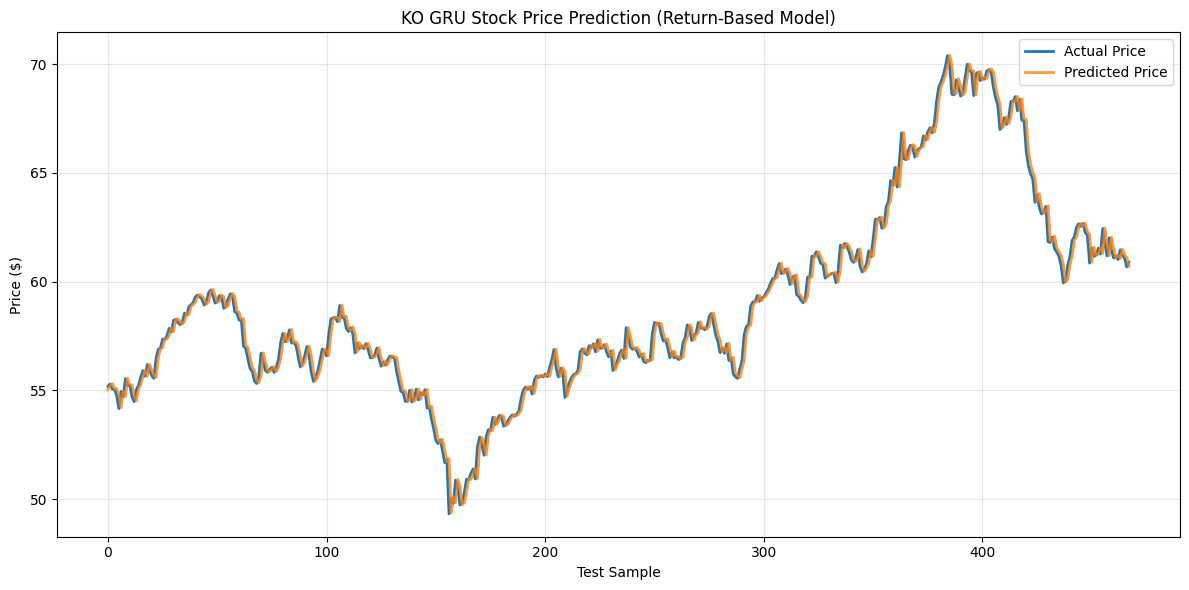


Forecast Summary:
Current Price: $60.90
Day 1 Forecast: $60.91 (Return: 0.0001)
Day 30 Forecast: $61.82
Total Expected Change: 1.51%

--- Processing INTC ---
Epoch 0 | Loss: 0.019655
Epoch 10 | Loss: 0.003037
Epoch 20 | Loss: 0.003060
Epoch 30 | Loss: 0.003000
Epoch 40 | Loss: 0.003077
Epoch 50 | Loss: 0.002968
Epoch 60 | Loss: 0.003028
Epoch 70 | Loss: 0.003079
Epoch 80 | Loss: 0.002961
Epoch 90 | Loss: 0.002957

Metrics (on Prices):
Close >> RMSE: $ 0.9332 R2: 0.9856 MAE: $ 0.6419 MAPE: 2.07%


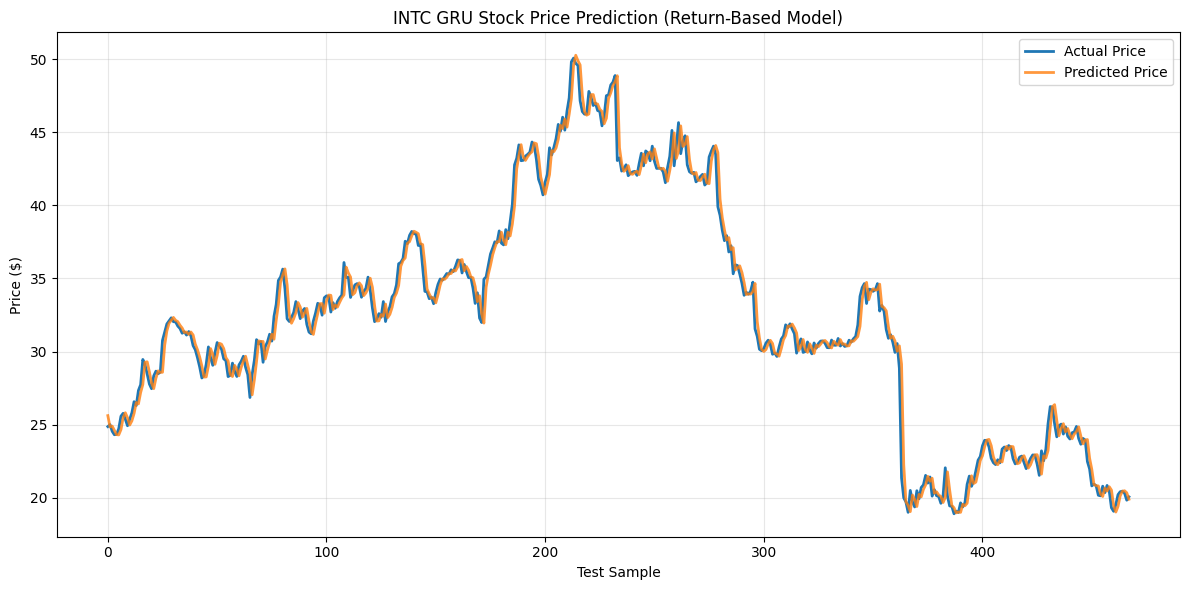


Forecast Summary:
Current Price: $20.05
Day 1 Forecast: $20.10 (Return: 0.0023)
Day 30 Forecast: $20.24
Total Expected Change: 0.97%

--- Processing CSCO ---
Epoch 0 | Loss: 0.015539
Epoch 10 | Loss: 0.003786
Epoch 20 | Loss: 0.003742
Epoch 30 | Loss: 0.003636
Epoch 40 | Loss: 0.003623
Epoch 50 | Loss: 0.003737
Epoch 60 | Loss: 0.003703
Epoch 70 | Loss: 0.003647
Epoch 80 | Loss: 0.003603
Epoch 90 | Loss: 0.003651

Metrics (on Prices):
Close >> RMSE: $ 0.5803 R2: 0.9756 MAE: $ 0.4024 MAPE: 0.84%


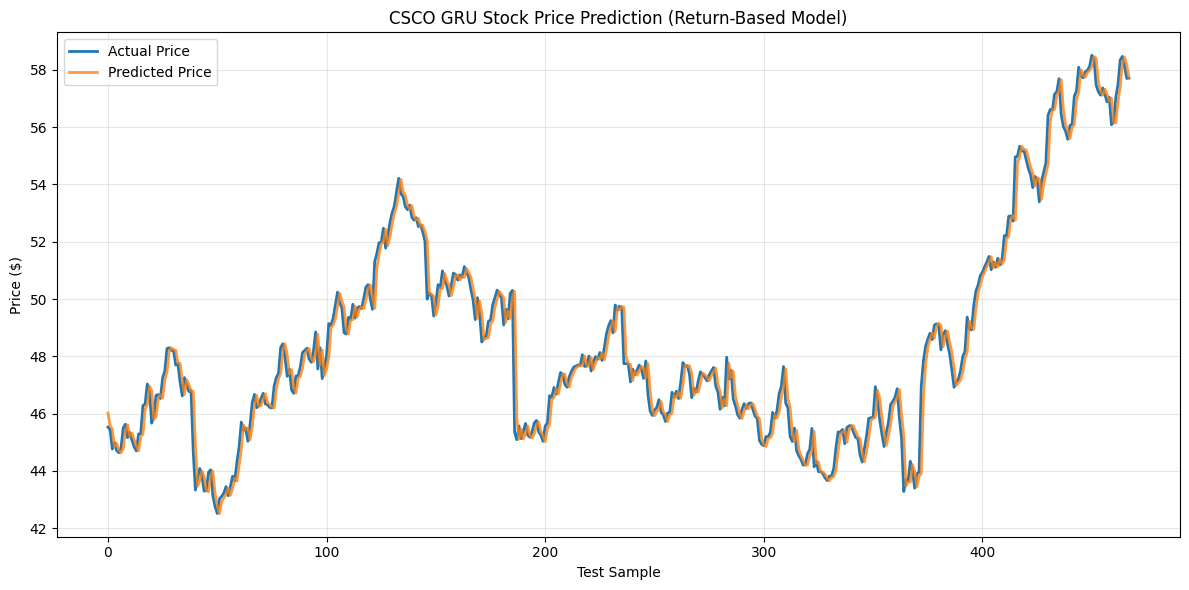


Forecast Summary:
Current Price: $57.71
Day 1 Forecast: $57.67 (Return: -0.0007)
Day 30 Forecast: $57.40
Total Expected Change: -0.54%

--- Processing NKE ---
Epoch 0 | Loss: 0.016287
Epoch 10 | Loss: 0.004511
Epoch 20 | Loss: 0.004500
Epoch 30 | Loss: 0.004561
Epoch 40 | Loss: 0.004476
Epoch 50 | Loss: 0.004530
Epoch 60 | Loss: 0.004484
Epoch 70 | Loss: 0.004781
Epoch 80 | Loss: 0.004424
Epoch 90 | Loss: 0.004443

Metrics (on Prices):
Close >> RMSE: $ 1.8315 R2: 0.9829 MAE: $ 1.1599 MAPE: 1.23%


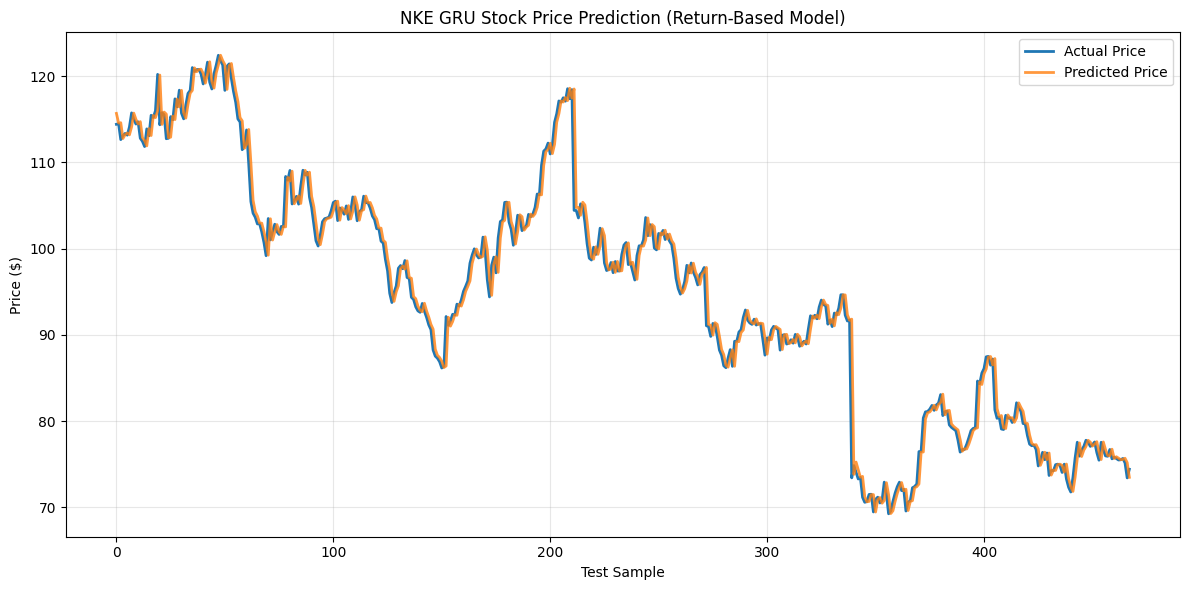


Forecast Summary:
Current Price: $74.41
Day 1 Forecast: $74.30 (Return: -0.0014)
Day 30 Forecast: $75.05
Total Expected Change: 0.86%

--- Processing MRK ---
Epoch 0 | Loss: 0.017288
Epoch 10 | Loss: 0.004796
Epoch 20 | Loss: 0.004683
Epoch 30 | Loss: 0.004702
Epoch 40 | Loss: 0.004639
Epoch 50 | Loss: 0.005052
Epoch 60 | Loss: 0.004654
Epoch 70 | Loss: 0.004644
Epoch 80 | Loss: 0.004615
Epoch 90 | Loss: 0.004594

Metrics (on Prices):
Close >> RMSE: $ 1.3816 R2: 0.9792 MAE: $ 0.9571 MAPE: 0.90%


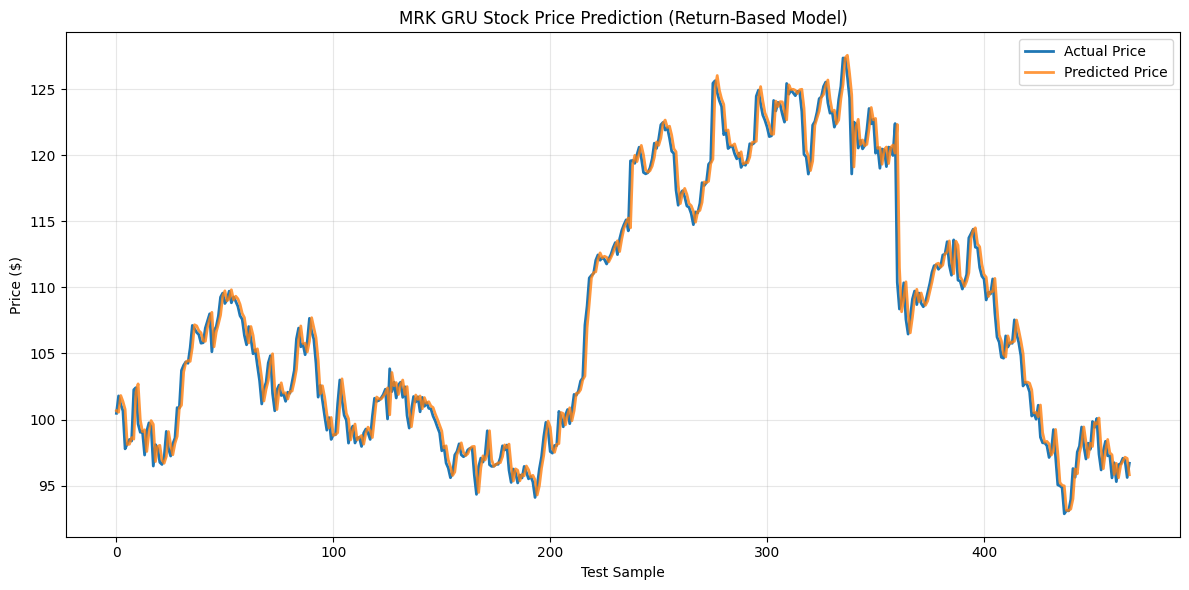


Forecast Summary:
Current Price: $96.70
Day 1 Forecast: $96.95 (Return: 0.0026)
Day 30 Forecast: $100.13
Total Expected Change: 3.55%

--- Processing PEP ---
Epoch 0 | Loss: 0.023056
Epoch 10 | Loss: 0.002577
Epoch 20 | Loss: 0.002524
Epoch 30 | Loss: 0.002481
Epoch 40 | Loss: 0.002473
Epoch 50 | Loss: 0.002834
Epoch 60 | Loss: 0.002479
Epoch 70 | Loss: 0.002521
Epoch 80 | Loss: 0.002426
Epoch 90 | Loss: 0.002435

Metrics (on Prices):
Close >> RMSE: $ 1.6239 R2: 0.9472 MAE: $ 1.2164 MAPE: 0.75%


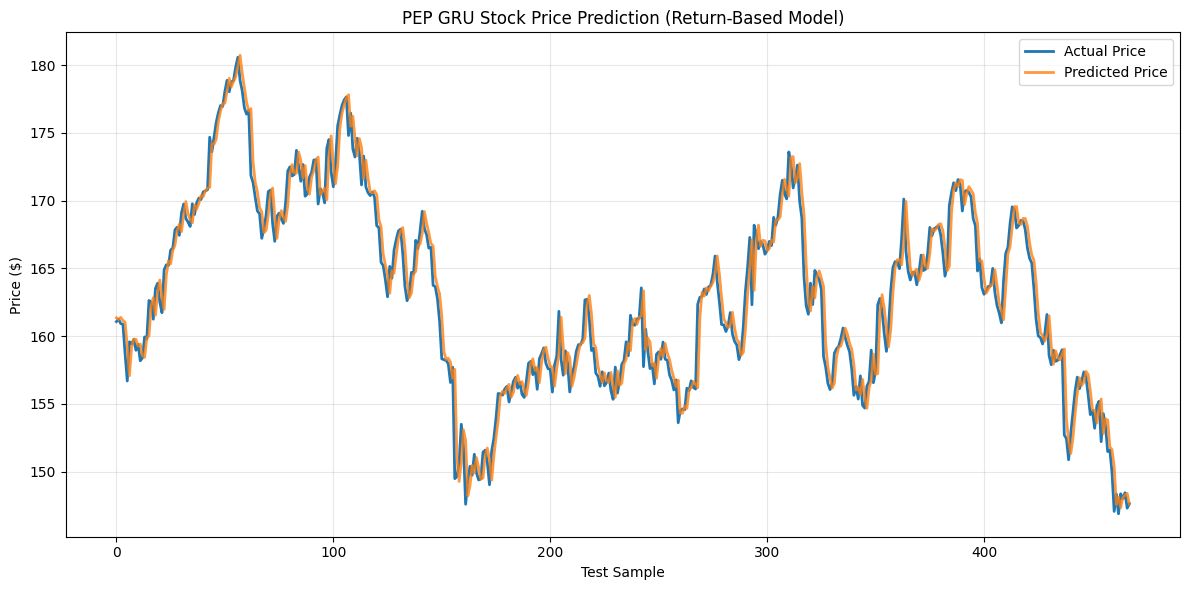


Forecast Summary:
Current Price: $147.65
Day 1 Forecast: $147.99 (Return: 0.0023)
Day 30 Forecast: $150.87
Total Expected Change: 2.18%

--- Processing ABBV ---
Epoch 0 | Loss: 0.042192
Epoch 10 | Loss: 0.003291
Epoch 20 | Loss: 0.003324
Epoch 30 | Loss: 0.003307
Epoch 40 | Loss: 0.003307
Epoch 50 | Loss: 0.003303
Epoch 60 | Loss: 0.003265
Epoch 70 | Loss: 0.003384
Epoch 80 | Loss: 0.003271
Epoch 90 | Loss: 0.003311

Metrics (on Prices):
Close >> RMSE: $ 2.2379 R2: 0.9870 MAE: $ 1.4175 MAPE: 0.92%


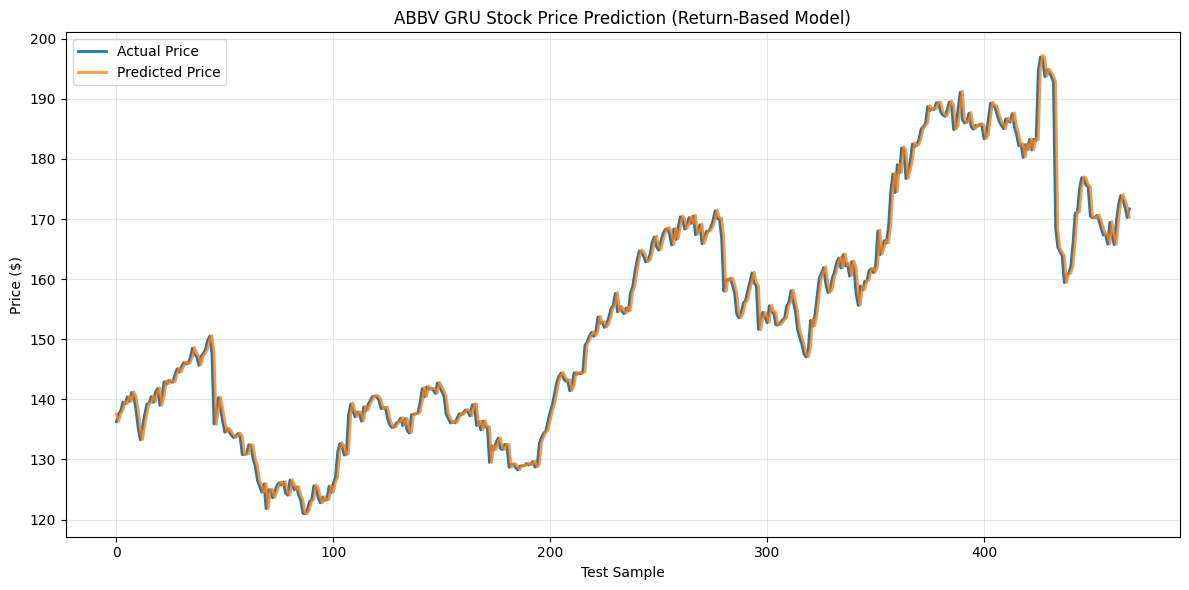


Forecast Summary:
Current Price: $171.70
Day 1 Forecast: $171.89 (Return: 0.0011)
Day 30 Forecast: $174.96
Total Expected Change: 1.90%

--- Processing ABT ---
Epoch 0 | Loss: 0.012792
Epoch 10 | Loss: 0.005743
Epoch 20 | Loss: 0.005720
Epoch 30 | Loss: 0.005805
Epoch 40 | Loss: 0.005689
Epoch 50 | Loss: 0.005688
Epoch 60 | Loss: 0.005662
Epoch 70 | Loss: 0.005731
Epoch 80 | Loss: 0.005722
Epoch 90 | Loss: 0.005626

Metrics (on Prices):
Close >> RMSE: $ 1.2258 R2: 0.9703 MAE: $ 0.9108 MAPE: 0.88%


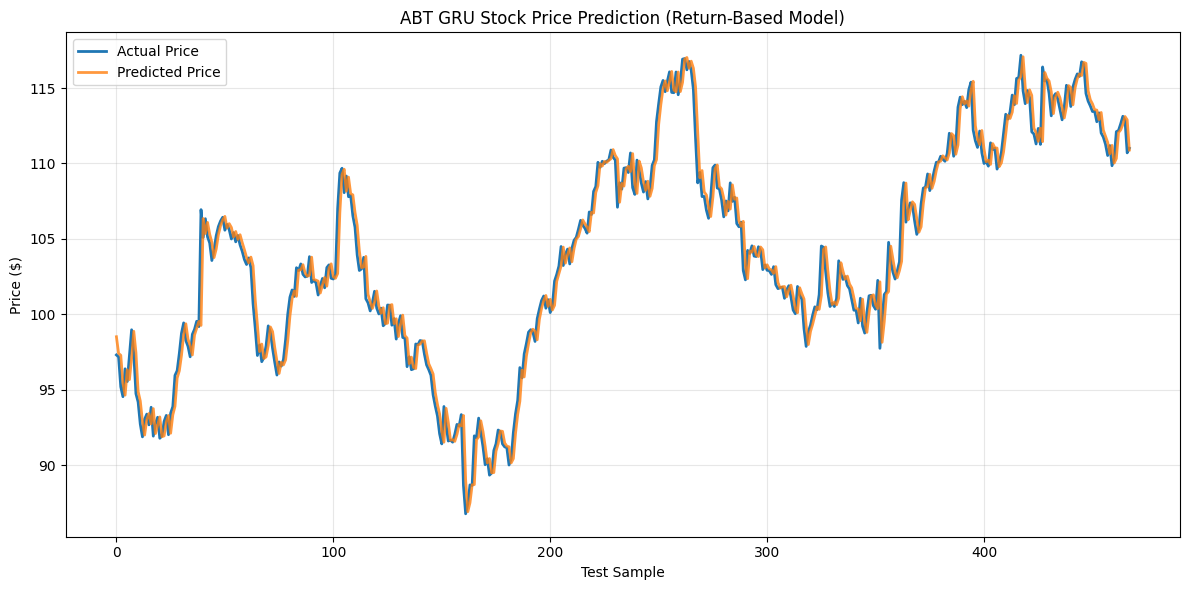


Forecast Summary:
Current Price: $111.01
Day 1 Forecast: $111.17 (Return: 0.0014)
Day 30 Forecast: $112.52
Total Expected Change: 1.36%

--- Processing CRM ---
Epoch 0 | Loss: 0.014489
Epoch 10 | Loss: 0.003049
Epoch 20 | Loss: 0.003032
Epoch 30 | Loss: 0.003053
Epoch 40 | Loss: 0.003076
Epoch 50 | Loss: 0.003036
Epoch 60 | Loss: 0.003007
Epoch 70 | Loss: 0.003009
Epoch 80 | Loss: 0.002990
Epoch 90 | Loss: 0.002984

Metrics (on Prices):
Close >> RMSE: $ 5.2985 R2: 0.9859 MAE: $ 3.3033 MAPE: 1.33%


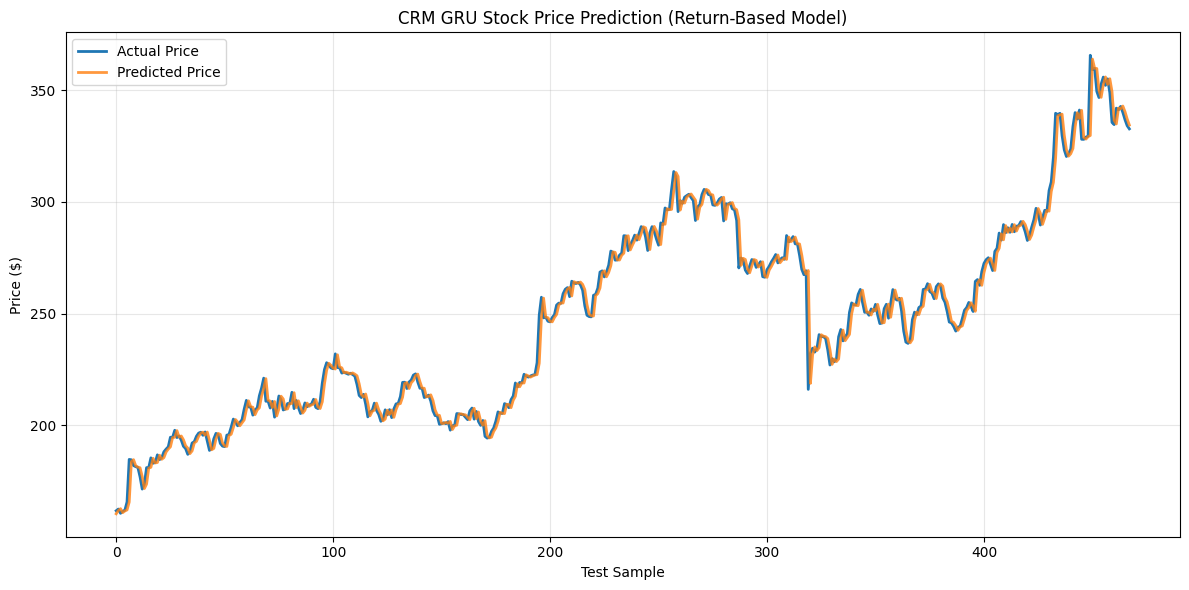


Forecast Summary:
Current Price: $332.70
Day 1 Forecast: $333.06 (Return: 0.0011)
Day 30 Forecast: $335.81
Total Expected Change: 0.93%

--- Processing ORCL ---
Epoch 0 | Loss: 0.012029
Epoch 10 | Loss: 0.003118
Epoch 20 | Loss: 0.003102
Epoch 30 | Loss: 0.003049
Epoch 40 | Loss: 0.003008
Epoch 50 | Loss: 0.003115
Epoch 60 | Loss: 0.003044
Epoch 70 | Loss: 0.003024
Epoch 80 | Loss: 0.002988
Epoch 90 | Loss: 0.002974

Metrics (on Prices):
Close >> RMSE: $ 2.5600 R2: 0.9909 MAE: $ 1.5817 MAPE: 1.27%


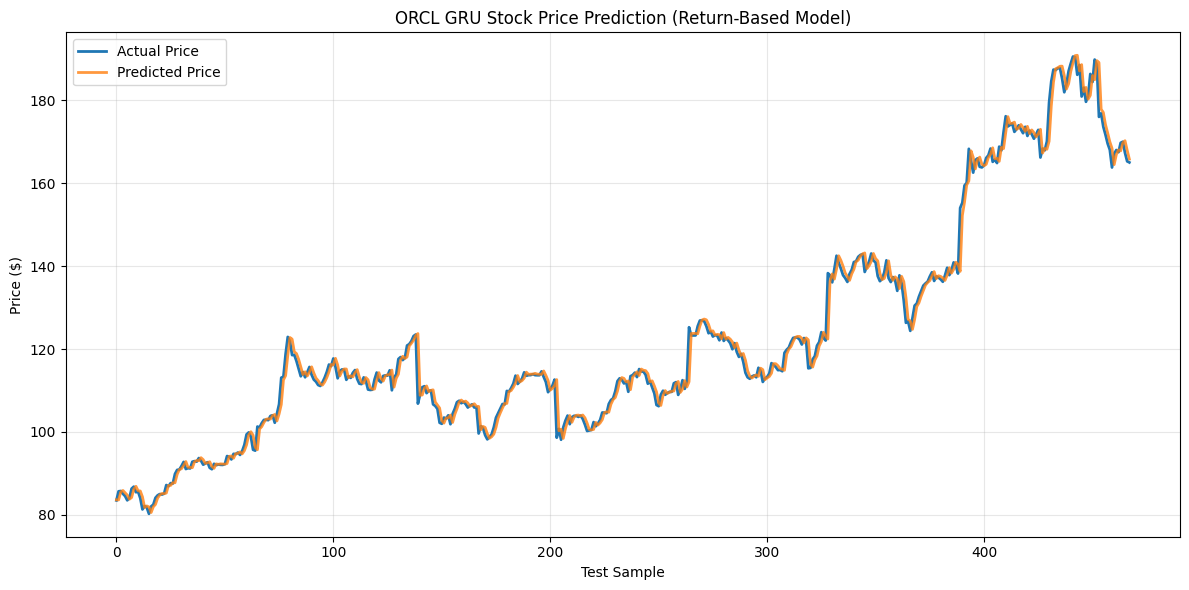


Forecast Summary:
Current Price: $165.00
Day 1 Forecast: $165.42 (Return: 0.0026)
Day 30 Forecast: $174.19
Total Expected Change: 5.57%

--- Processing T ---
Epoch 0 | Loss: 0.015816
Epoch 10 | Loss: 0.005666
Epoch 20 | Loss: 0.005494
Epoch 30 | Loss: 0.005585
Epoch 40 | Loss: 0.005629
Epoch 50 | Loss: 0.005461
Epoch 60 | Loss: 0.005951
Epoch 70 | Loss: 0.005450
Epoch 80 | Loss: 0.005444
Epoch 90 | Loss: 0.005469

Metrics (on Prices):
Close >> RMSE: $ 0.2394 R2: 0.9925 MAE: $ 0.1662 MAPE: 1.03%


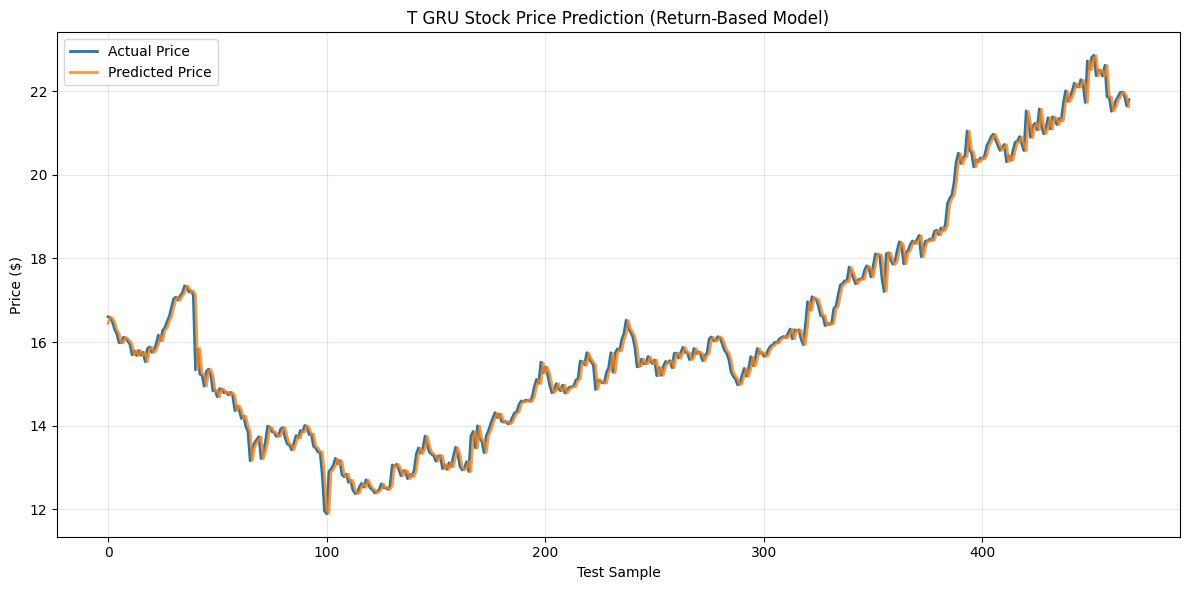


Forecast Summary:
Current Price: $21.79
Day 1 Forecast: $21.79 (Return: -0.0002)
Day 30 Forecast: $21.74
Total Expected Change: -0.25%

--- Processing VZ ---
Epoch 0 | Loss: 0.049657
Epoch 10 | Loss: 0.006784
Epoch 20 | Loss: 0.006741
Epoch 30 | Loss: 0.006735
Epoch 40 | Loss: 0.006761
Epoch 50 | Loss: 0.006755
Epoch 60 | Loss: 0.006805
Epoch 70 | Loss: 0.006733
Epoch 80 | Loss: 0.006722
Epoch 90 | Loss: 0.006670

Metrics (on Prices):
Close >> RMSE: $ 0.4712 R2: 0.9858 MAE: $ 0.3214 MAPE: 0.94%


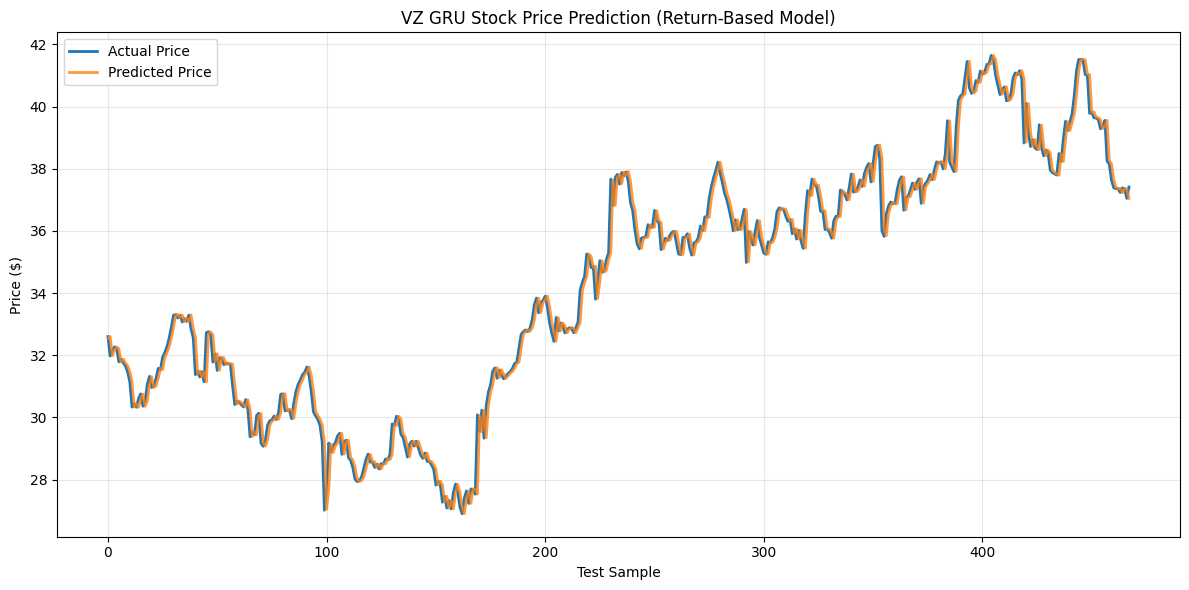


Forecast Summary:
Current Price: $37.41
Day 1 Forecast: $37.41 (Return: -0.0002)
Day 30 Forecast: $37.55
Total Expected Change: 0.36%

--- Processing CVX ---
Epoch 0 | Loss: 0.034611
Epoch 10 | Loss: 0.001974
Epoch 20 | Loss: 0.001914
Epoch 30 | Loss: 0.001995
Epoch 40 | Loss: 0.001945
Epoch 50 | Loss: 0.001884
Epoch 60 | Loss: 0.001919
Epoch 70 | Loss: 0.001916
Epoch 80 | Loss: 0.001902
Epoch 90 | Loss: 0.001890

Metrics (on Prices):
Close >> RMSE: $ 1.9000 R2: 0.9128 MAE: $ 1.3999 MAPE: 0.97%


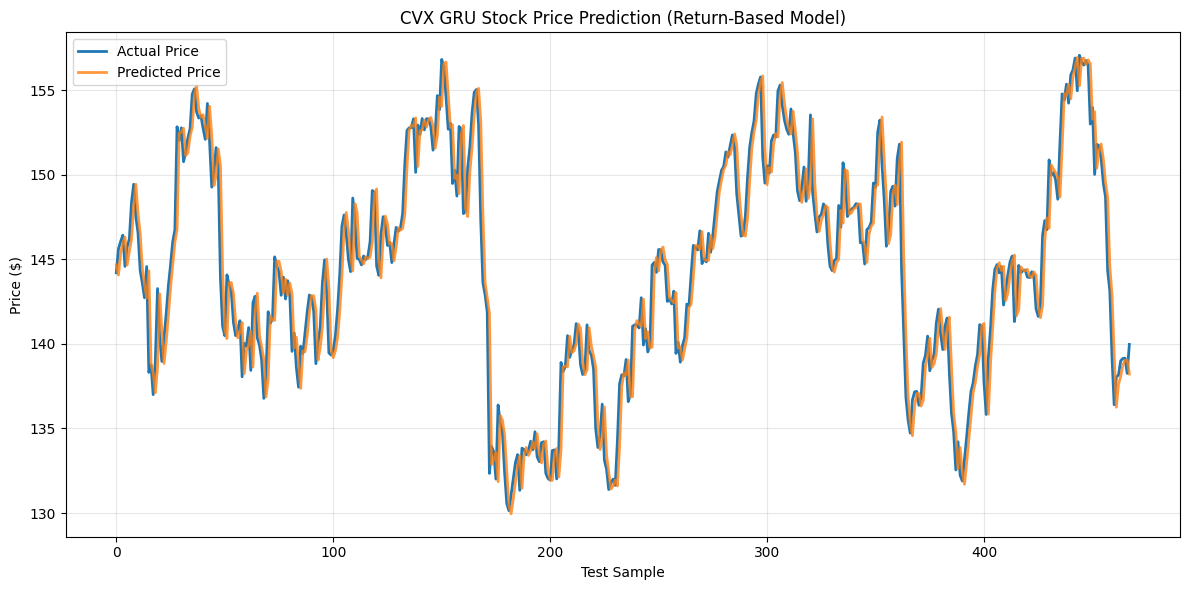


Forecast Summary:
Current Price: $139.97
Day 1 Forecast: $139.89 (Return: -0.0005)
Day 30 Forecast: $138.82
Total Expected Change: -0.82%

--- Processing MCD ---
Epoch 0 | Loss: 0.016104
Epoch 10 | Loss: 0.001642
Epoch 20 | Loss: 0.001590
Epoch 30 | Loss: 0.001573
Epoch 40 | Loss: 0.001583
Epoch 50 | Loss: 0.001563
Epoch 60 | Loss: 0.001540
Epoch 70 | Loss: 0.001560
Epoch 80 | Loss: 0.001530
Epoch 90 | Loss: 0.001542

Metrics (on Prices):
Close >> RMSE: $ 2.7250 R2: 0.9690 MAE: $ 2.0063 MAPE: 0.75%


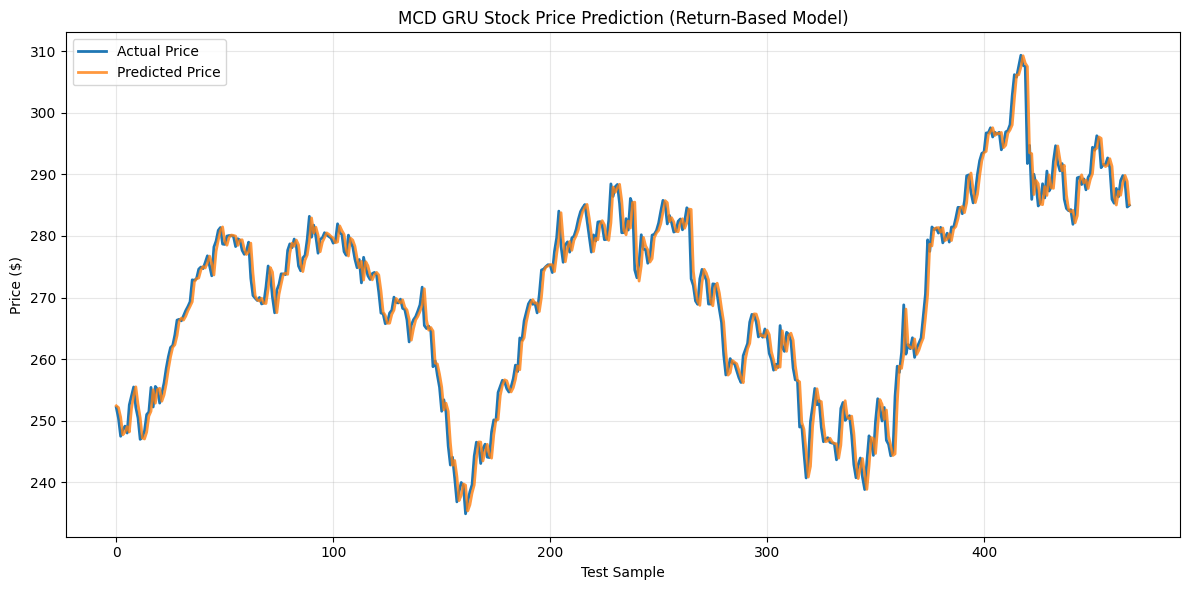


Forecast Summary:
Current Price: $284.98
Day 1 Forecast: $285.41 (Return: 0.0015)
Day 30 Forecast: $286.02
Total Expected Change: 0.37%

--- Processing WMT ---
Epoch 0 | Loss: 0.020242
Epoch 10 | Loss: 0.003706
Epoch 20 | Loss: 0.003645
Epoch 30 | Loss: 0.003677
Epoch 40 | Loss: 0.003646
Epoch 50 | Loss: 0.003598
Epoch 60 | Loss: 0.003630
Epoch 70 | Loss: 0.003671
Epoch 80 | Loss: 0.003631
Epoch 90 | Loss: 0.003633

Metrics (on Prices):
Close >> RMSE: $ 0.6782 R2: 0.9973 MAE: $ 0.4606 MAPE: 0.74%


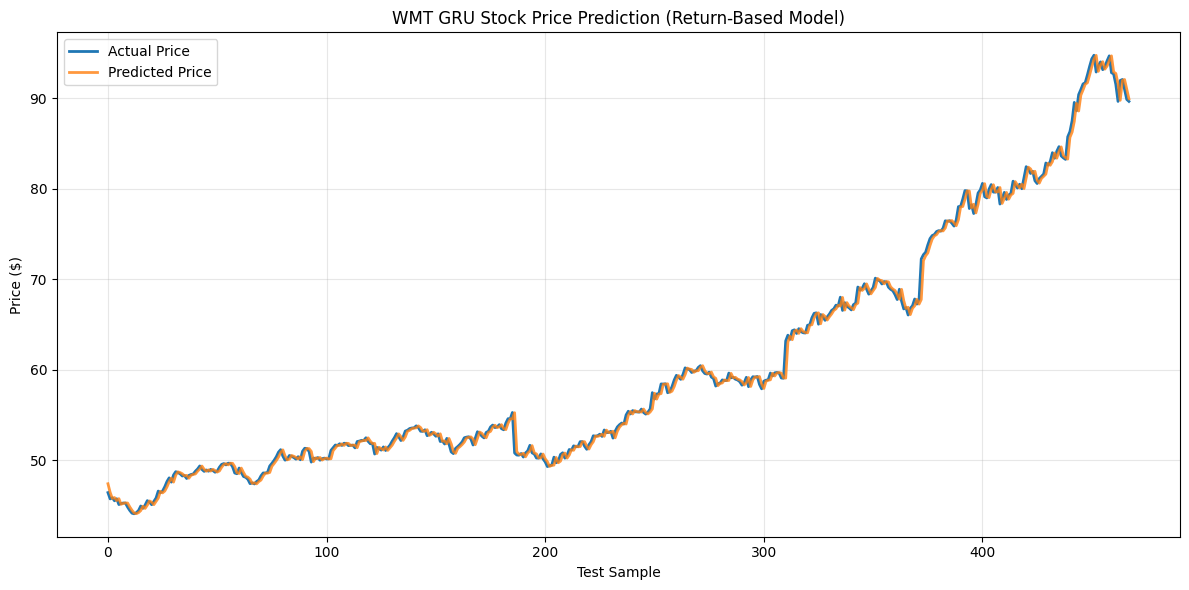


Forecast Summary:
Current Price: $89.68
Day 1 Forecast: $89.73 (Return: 0.0006)
Day 30 Forecast: $90.20
Total Expected Change: 0.58%

--- Processing DHR ---
Epoch 0 | Loss: 0.001574
Epoch 10 | Loss: 0.001043
Epoch 20 | Loss: 0.001014
Epoch 30 | Loss: 0.001020
Epoch 40 | Loss: 0.001051
Epoch 50 | Loss: 0.001007
Epoch 60 | Loss: 0.001002
Epoch 70 | Loss: 0.001010
Epoch 80 | Loss: 0.001004
Epoch 90 | Loss: 0.000999

Metrics (on Prices):
Close >> RMSE: $ 3.4295 R2: 0.9757 MAE: $ 2.4985 MAPE: 1.08%


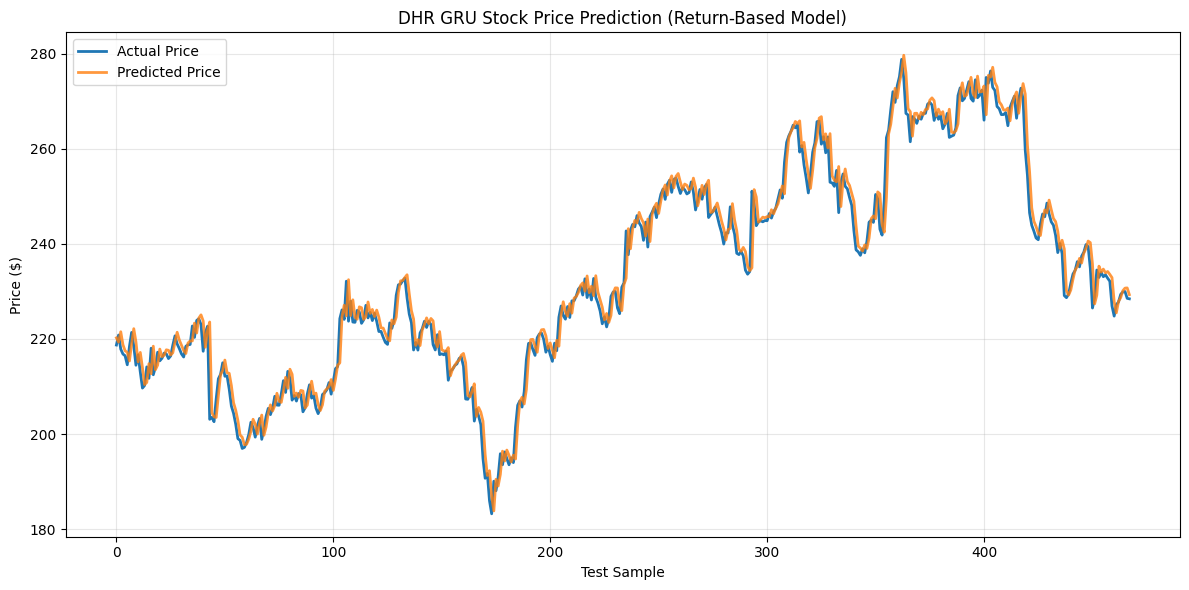


Forecast Summary:
Current Price: $228.43
Day 1 Forecast: $229.30 (Return: 0.0038)
Day 30 Forecast: $251.24
Total Expected Change: 9.98%

--- Processing ACN ---
Epoch 0 | Loss: 0.021284
Epoch 10 | Loss: 0.006006
Epoch 20 | Loss: 0.005927
Epoch 30 | Loss: 0.005846
Epoch 40 | Loss: 0.005825
Epoch 50 | Loss: 0.005729
Epoch 60 | Loss: 0.005698
Epoch 70 | Loss: 0.005869
Epoch 80 | Loss: 0.005717
Epoch 90 | Loss: 0.005712

Metrics (on Prices):
Close >> RMSE: $ 4.6577 R2: 0.9792 MAE: $ 3.2895 MAPE: 1.05%


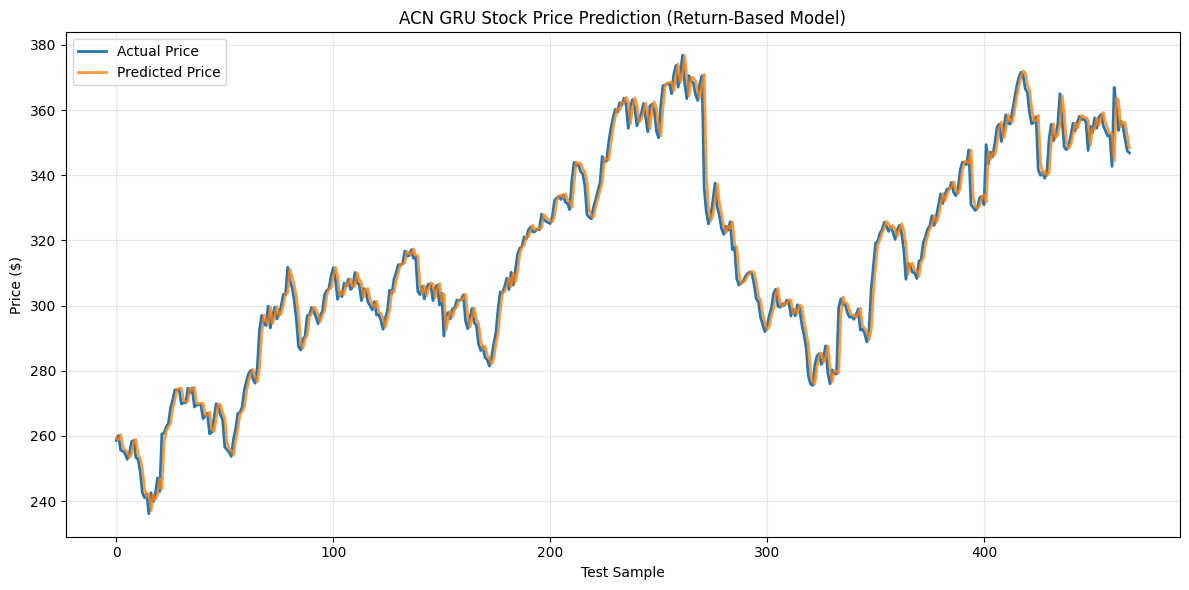


Forecast Summary:
Current Price: $346.84
Day 1 Forecast: $347.39 (Return: 0.0016)
Day 30 Forecast: $359.29
Total Expected Change: 3.59%

--- Processing LLY ---
Epoch 0 | Loss: 0.015578
Epoch 10 | Loss: 0.004686
Epoch 20 | Loss: 0.004500
Epoch 30 | Loss: 0.004530
Epoch 40 | Loss: 0.004595
Epoch 50 | Loss: 0.004476
Epoch 60 | Loss: 0.004592
Epoch 70 | Loss: 0.004480
Epoch 80 | Loss: 0.004454
Epoch 90 | Loss: 0.004475

Metrics (on Prices):
Close >> RMSE: $ 12.9228 R2: 0.9952 MAE: $ 8.4681 MAPE: 1.27%


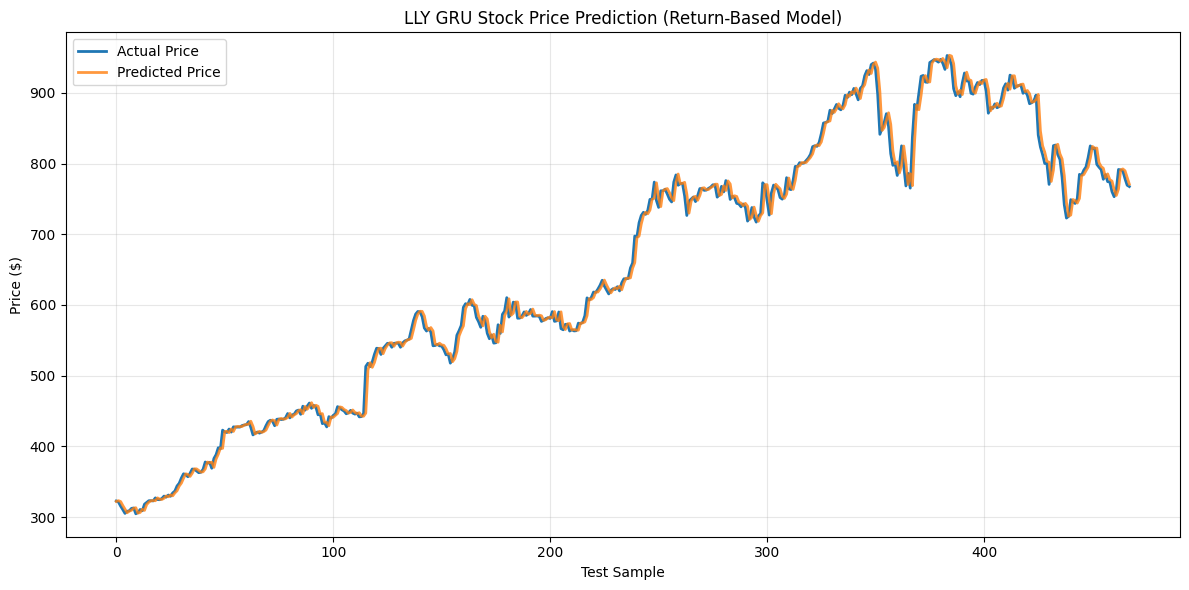


Forecast Summary:
Current Price: $767.41
Day 1 Forecast: $769.15 (Return: 0.0023)
Day 30 Forecast: $803.41
Total Expected Change: 4.69%

--- Processing AVGO ---
Epoch 0 | Loss: 0.018286
Epoch 10 | Loss: 0.003971
Epoch 20 | Loss: 0.003671
Epoch 30 | Loss: 0.003627
Epoch 40 | Loss: 0.003643
Epoch 50 | Loss: 0.003609
Epoch 60 | Loss: 0.003621
Epoch 70 | Loss: 0.003564
Epoch 80 | Loss: 0.003582
Epoch 90 | Loss: 0.003556

Metrics (on Prices):
Close >> RMSE: $ 4.3200 R2: 0.9895 MAE: $ 2.4774 MAPE: 1.91%


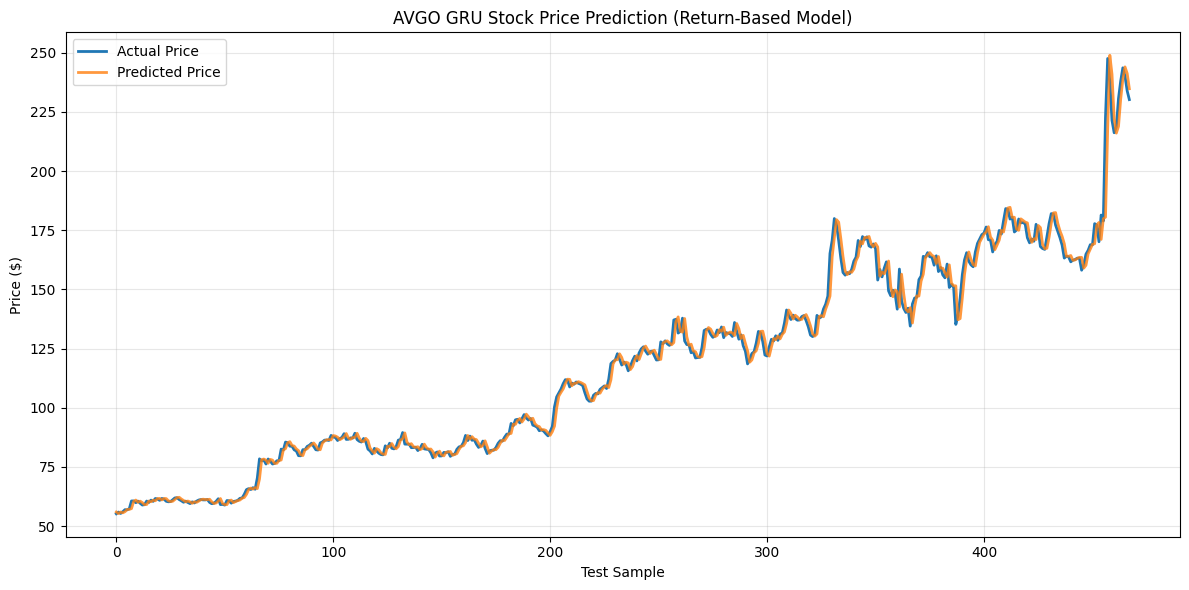


Forecast Summary:
Current Price: $230.20
Day 1 Forecast: $230.95 (Return: 0.0033)
Day 30 Forecast: $246.95
Total Expected Change: 7.27%

--- Processing QCOM ---
Epoch 0 | Loss: 0.012982
Epoch 10 | Loss: 0.004056
Epoch 20 | Loss: 0.004031
Epoch 30 | Loss: 0.004042
Epoch 40 | Loss: 0.003968
Epoch 50 | Loss: 0.004020
Epoch 60 | Loss: 0.003963
Epoch 70 | Loss: 0.003987
Epoch 80 | Loss: 0.003909
Epoch 90 | Loss: 0.003897

Metrics (on Prices):
Close >> RMSE: $ 3.3349 R2: 0.9880 MAE: $ 2.3161 MAPE: 1.59%


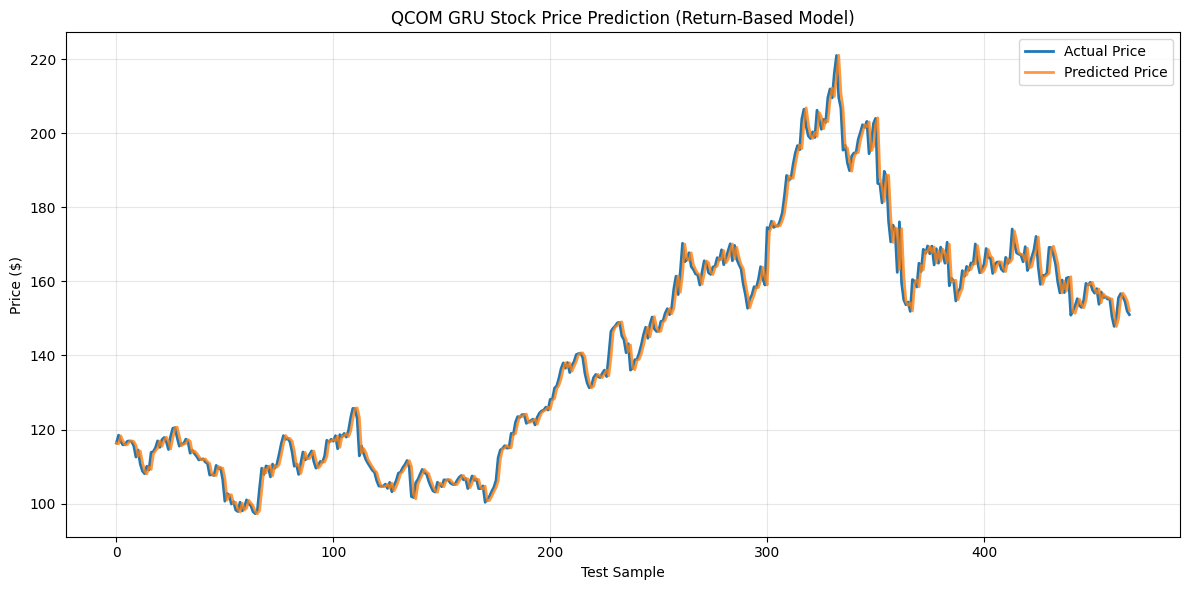


Forecast Summary:
Current Price: $151.02
Day 1 Forecast: $151.31 (Return: 0.0019)
Day 30 Forecast: $151.43
Total Expected Change: 0.27%

--- Processing TXN ---
Epoch 0 | Loss: 0.028997
Epoch 10 | Loss: 0.005215
Epoch 20 | Loss: 0.005177
Epoch 30 | Loss: 0.005085
Epoch 40 | Loss: 0.005203
Epoch 50 | Loss: 0.005134
Epoch 60 | Loss: 0.005232
Epoch 70 | Loss: 0.005094
Epoch 80 | Loss: 0.005046
Epoch 90 | Loss: 0.005086

Metrics (on Prices):
Close >> RMSE: $ 2.8016 R2: 0.9774 MAE: $ 2.1115 MAPE: 1.23%


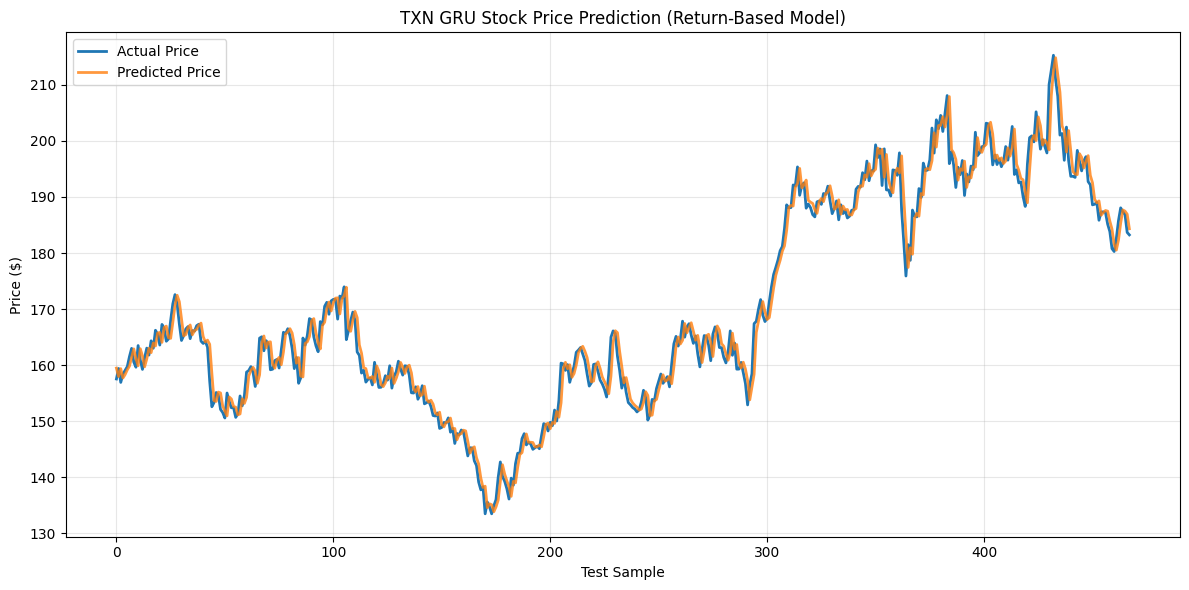


Forecast Summary:
Current Price: $183.23
Day 1 Forecast: $184.13 (Return: 0.0049)
Day 30 Forecast: $189.66
Total Expected Change: 3.51%

--- Processing NEE ---
Epoch 0 | Loss: 0.032559
Epoch 10 | Loss: 0.003157
Epoch 20 | Loss: 0.003018
Epoch 30 | Loss: 0.003097
Epoch 40 | Loss: 0.002989
Epoch 50 | Loss: 0.002994
Epoch 60 | Loss: 0.003018
Epoch 70 | Loss: 0.003013
Epoch 80 | Loss: 0.003015
Epoch 90 | Loss: 0.003050

Metrics (on Prices):
Close >> RMSE: $ 1.0731 R2: 0.9845 MAE: $ 0.7825 MAPE: 1.20%


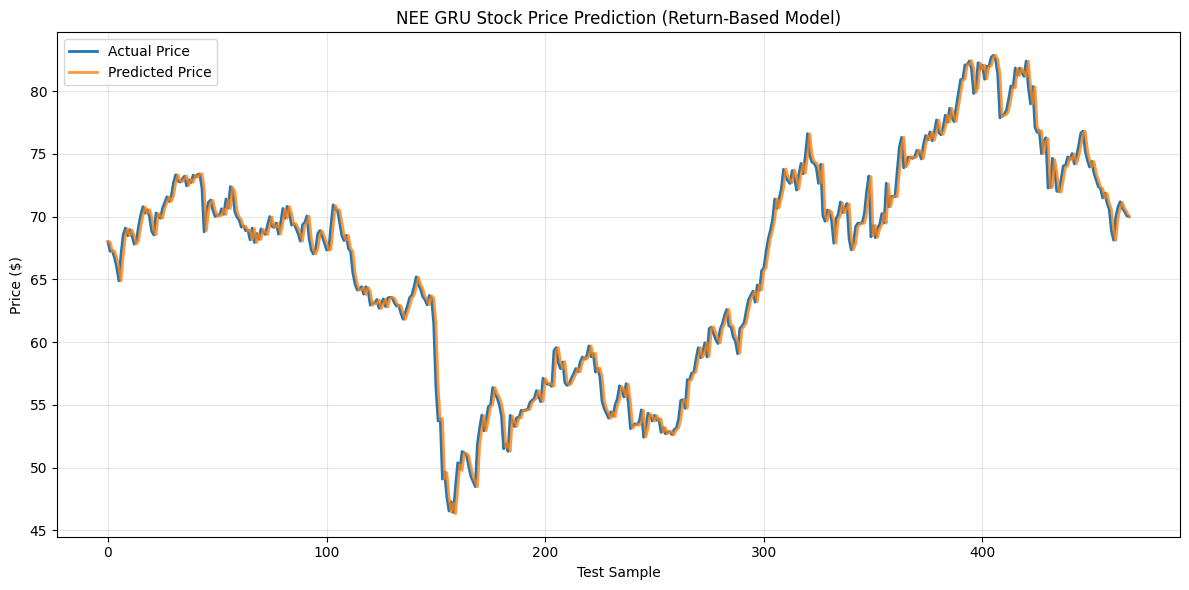


Forecast Summary:
Current Price: $69.99
Day 1 Forecast: $70.02 (Return: 0.0004)
Day 30 Forecast: $69.09
Total Expected Change: -1.28%

--- Processing COST ---
Epoch 0 | Loss: 0.036067
Epoch 10 | Loss: 0.003939
Epoch 20 | Loss: 0.003881
Epoch 30 | Loss: 0.003922
Epoch 40 | Loss: 0.003896
Epoch 50 | Loss: 0.003905
Epoch 60 | Loss: 0.003872
Epoch 70 | Loss: 0.003830
Epoch 80 | Loss: 0.003851
Epoch 90 | Loss: 0.003819

Metrics (on Prices):
Close >> RMSE: $ 8.2275 R2: 0.9975 MAE: $ 5.8802 MAPE: 0.85%


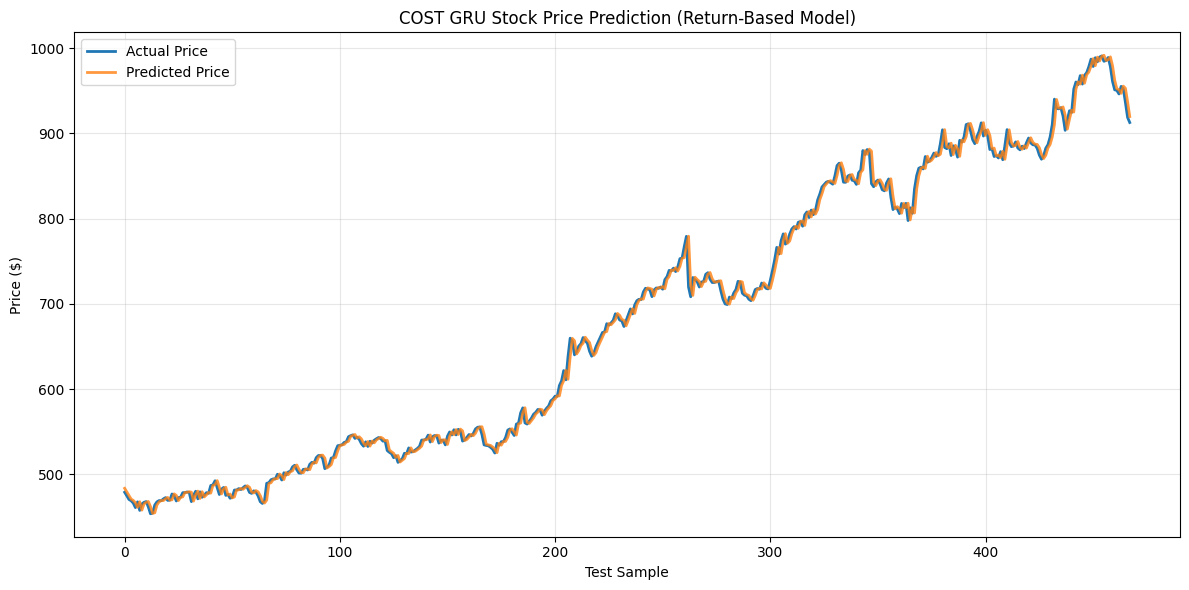


Forecast Summary:
Current Price: $912.80
Day 1 Forecast: $914.73 (Return: 0.0021)
Day 30 Forecast: $931.39
Total Expected Change: 2.04%

--- Processing TMUS ---
Epoch 0 | Loss: 0.015279
Epoch 10 | Loss: 0.005950
Epoch 20 | Loss: 0.005744
Epoch 30 | Loss: 0.005797
Epoch 40 | Loss: 0.005759
Epoch 50 | Loss: 0.005752
Epoch 60 | Loss: 0.005740
Epoch 70 | Loss: 0.005683
Epoch 80 | Loss: 0.005707
Epoch 90 | Loss: 0.005825

Metrics (on Prices):
Close >> RMSE: $ 1.9708 R2: 0.9959 MAE: $ 1.3345 MAPE: 0.81%


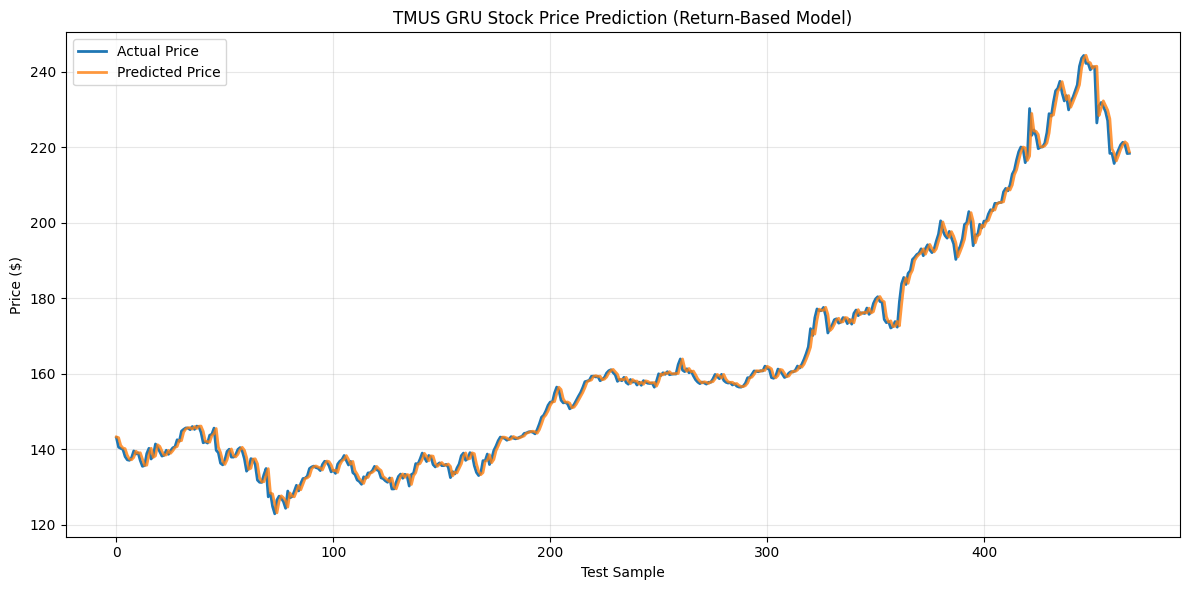


Forecast Summary:
Current Price: $218.42
Day 1 Forecast: $218.85 (Return: 0.0020)
Day 30 Forecast: $223.16
Total Expected Change: 2.17%

--- Processing IBM ---
Epoch 0 | Loss: 0.028008
Epoch 10 | Loss: 0.004124
Epoch 20 | Loss: 0.004293
Epoch 30 | Loss: 0.004103
Epoch 40 | Loss: 0.004176
Epoch 50 | Loss: 0.004148
Epoch 60 | Loss: 0.004083
Epoch 70 | Loss: 0.004079
Epoch 80 | Loss: 0.004073
Epoch 90 | Loss: 0.004066

Metrics (on Prices):
Close >> RMSE: $ 2.1883 R2: 0.9959 MAE: $ 1.4152 MAPE: 0.86%


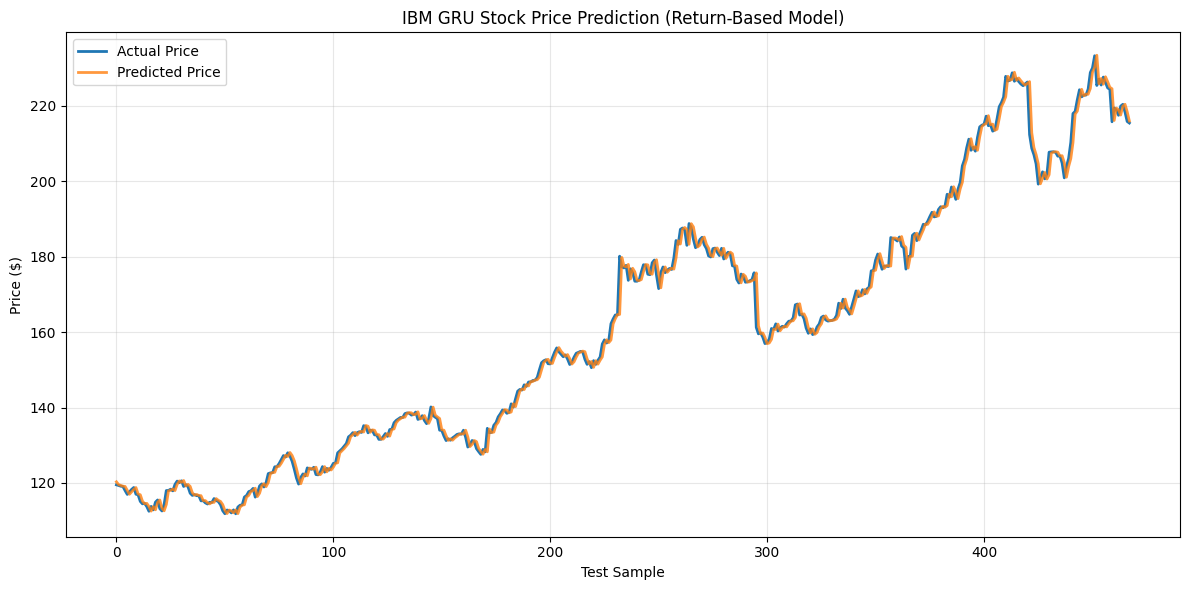


Forecast Summary:
Current Price: $215.47
Day 1 Forecast: $215.36 (Return: -0.0005)
Day 30 Forecast: $218.43
Total Expected Change: 1.37%

--- Processing SBUX ---
Epoch 0 | Loss: 0.019832
Epoch 10 | Loss: 0.003035
Epoch 20 | Loss: 0.003204
Epoch 30 | Loss: 0.003131
Epoch 40 | Loss: 0.003041
Epoch 50 | Loss: 0.003044
Epoch 60 | Loss: 0.003017
Epoch 70 | Loss: 0.003018
Epoch 80 | Loss: 0.003026
Epoch 90 | Loss: 0.003009

Metrics (on Prices):
Close >> RMSE: $ 1.6740 R2: 0.9560 MAE: $ 0.9896 MAPE: 1.11%


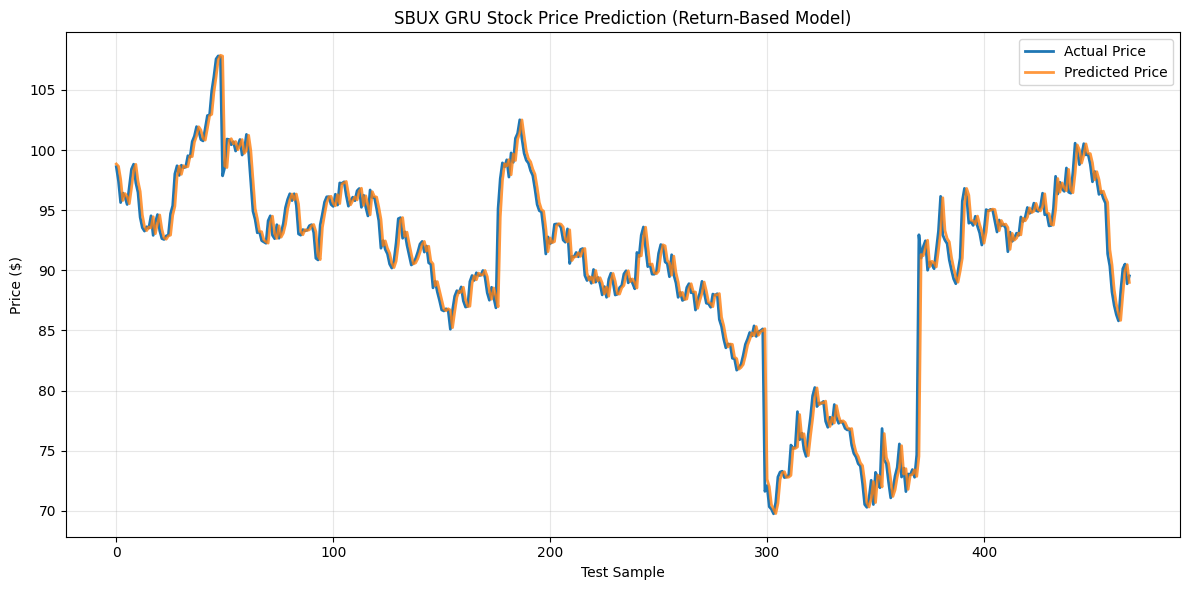


Forecast Summary:
Current Price: $89.53
Day 1 Forecast: $89.59 (Return: 0.0006)
Day 30 Forecast: $89.15
Total Expected Change: -0.43%

--- Processing MDT ---
Epoch 0 | Loss: 0.020868
Epoch 10 | Loss: 0.004272
Epoch 20 | Loss: 0.004193
Epoch 30 | Loss: 0.004071
Epoch 40 | Loss: 0.004202
Epoch 50 | Loss: 0.004187
Epoch 60 | Loss: 0.004066
Epoch 70 | Loss: 0.004055
Epoch 80 | Loss: 0.004051
Epoch 90 | Loss: 0.004059

Metrics (on Prices):
Close >> RMSE: $ 0.9413 R2: 0.9637 MAE: $ 0.6880 MAPE: 0.88%


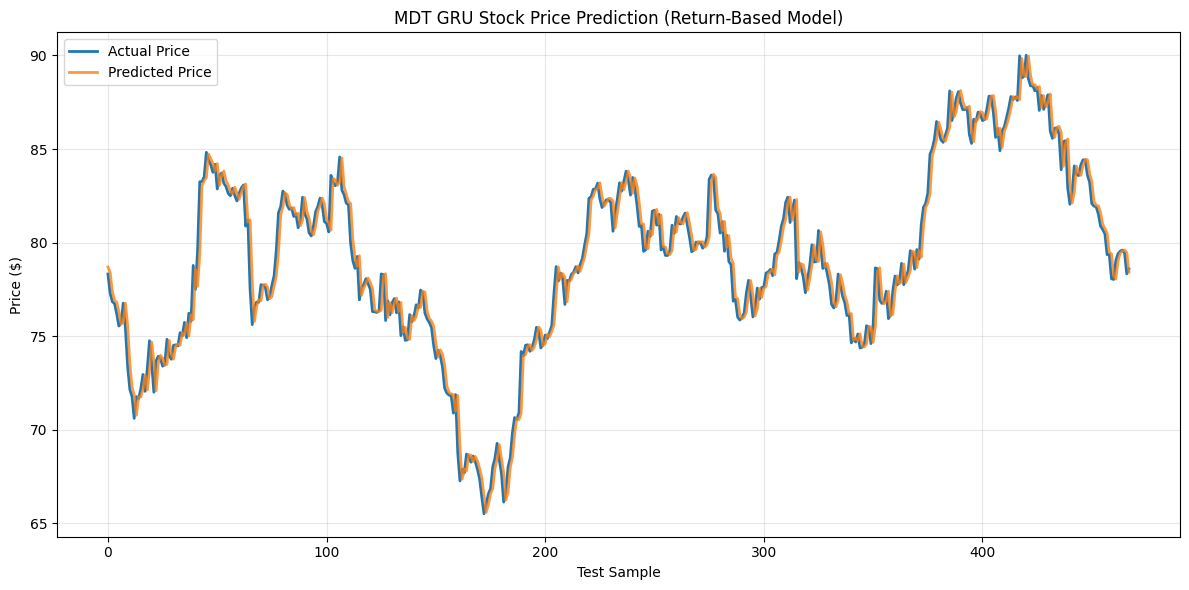


Forecast Summary:
Current Price: $78.60
Day 1 Forecast: $78.70 (Return: 0.0013)
Day 30 Forecast: $79.19
Total Expected Change: 0.76%

--- Processing HON ---
Epoch 0 | Loss: 0.019293
Epoch 10 | Loss: 0.003202
Epoch 20 | Loss: 0.003197
Epoch 30 | Loss: 0.003191
Epoch 40 | Loss: 0.003146
Epoch 50 | Loss: 0.003193
Epoch 60 | Loss: 0.003120
Epoch 70 | Loss: 0.003207
Epoch 80 | Loss: 0.003131
Epoch 90 | Loss: 0.003121

Metrics (on Prices):
Close >> RMSE: $ 2.1948 R2: 0.9715 MAE: $ 1.6034 MAPE: 0.82%


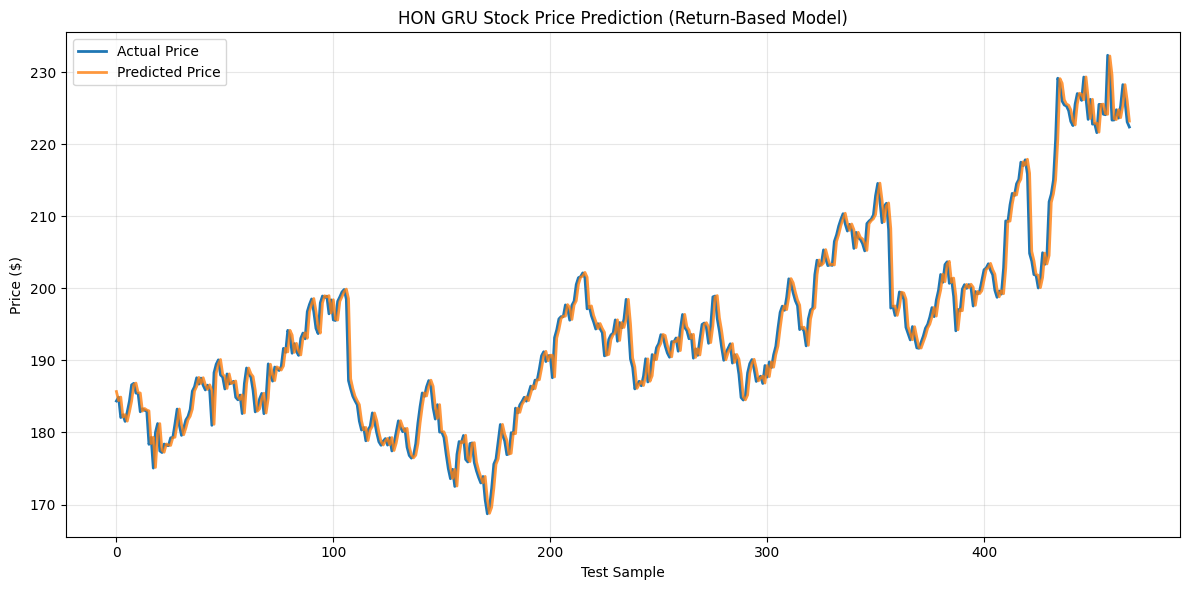


Forecast Summary:
Current Price: $222.39
Day 1 Forecast: $222.36 (Return: -0.0001)
Day 30 Forecast: $224.43
Total Expected Change: 0.92%

--- Processing AMD ---
Epoch 0 | Loss: 0.009572
Epoch 10 | Loss: 0.003031
Epoch 20 | Loss: 0.003054
Epoch 30 | Loss: 0.002941
Epoch 40 | Loss: 0.002986
Epoch 50 | Loss: 0.002960
Epoch 60 | Loss: 0.002926
Epoch 70 | Loss: 0.002945
Epoch 80 | Loss: 0.002910
Epoch 90 | Loss: 0.002960

Metrics (on Prices):
Close >> RMSE: $ 4.1180 R2: 0.9813 MAE: $ 2.9202 MAPE: 2.16%


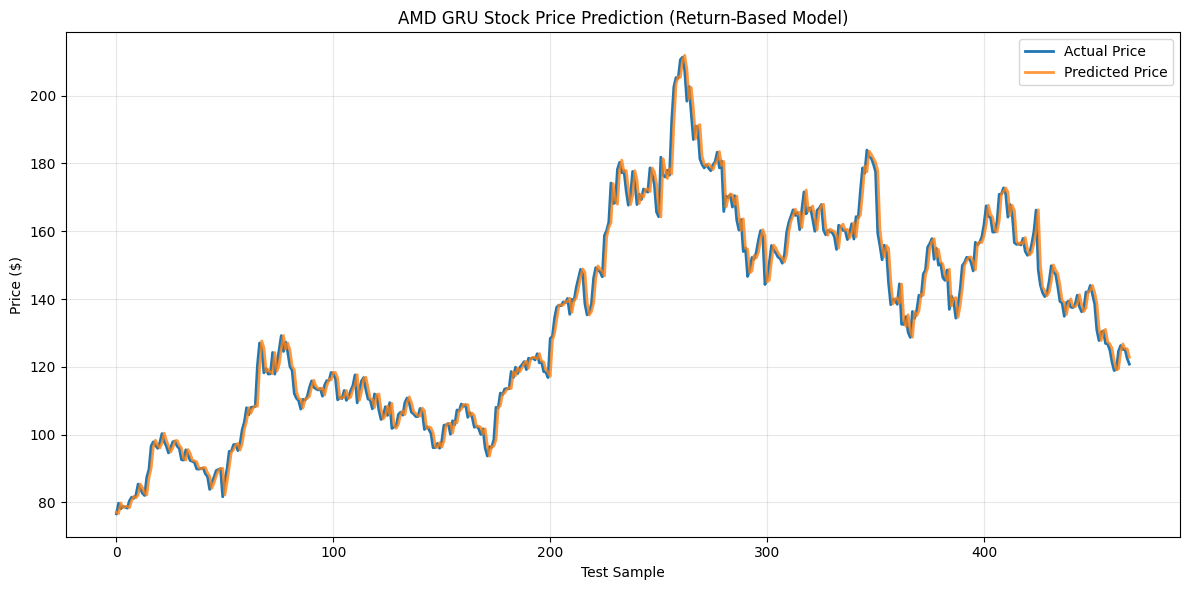


Forecast Summary:
Current Price: $120.79
Day 1 Forecast: $121.13 (Return: 0.0028)
Day 30 Forecast: $127.32
Total Expected Change: 5.40%

GRU processing complete.
Processed stocks: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'AAPL', 'MSFT', 'AAPL', 'MSFT', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'V', 'UNH', 'HD', 'PG', 'DIS', 'MA', 'BAC', 'NFLX', 'ADBE', 'PYPL', 'CMCSA', 'XOM', 'PFE', 'KO', 'INTC', 'CSCO', 'NKE', 'MRK', 'PEP', 'ABBV', 'ABT', 'CRM', 'ORCL', 'T', 'VZ', 'CVX', 'MCD', 'WMT', 'DHR', 'ACN', 'LLY', 'AVGO', 'QCOM', 'TXN', 'NEE', 'COST', 'TMUS', 'IBM', 'SBUX', 'MDT', 'HON', 'AMD']
Skipped stocks: []


In [22]:
for symbol in stocks:
    print(f"\n--- Processing {symbol} ---")
    # Find latest processed CSV for the symbol
    files = glob.glob(f"{processed_folder}/{symbol}_processed*.csv")
    if files:
        processed_file = sorted(files)[-1]  # pick the latest file
    else:
        print(f"Processed file for {symbol} not found. Skipping.")
        skipped_stocks.append(symbol)
        continue

    ######## 
    SEQ_LEN = 30  
    EPOCHS = 100 
    BATCH_SIZE = 32

    data = pd.read_csv(processed_file, parse_dates=['Price'])
    prices = data["Close"].values.reshape(-1, 1)
    returns = np.diff(np.log(prices), axis=0) 

    original_prices = prices.copy()

    ######## Test and train stuff
    train_size = int(len(returns) * 0.8)
    returns_train = returns[:train_size]
    returns_test = returns[train_size:]

    last_train_price = prices[train_size]

    scaler = MinMaxScaler()

    returns_train_scaled = scaler.fit_transform(returns_train)
    returns_test_scaled = scaler.transform(returns_test)

    X_train, y_train = create_sequences(returns_train_scaled, SEQ_LEN)
    X_test, y_test = create_sequences(returns_test_scaled, SEQ_LEN)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

    ######## Initialize model
    GRU = nn.GRU(1, 64, 2, batch_first=True)
    connection_density = nn.Linear(64, 1)

    criterion = nn.MSELoss()

    optimizer = torch.optim.AdamW(list(GRU.parameters()) + list(connection_density.parameters()), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    ######## Looping epoch 
    for epoch in range(EPOCHS):
        GRU.train()
        connection_density.train()

        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out, _ = GRU(batch_X)
            preds = connection_density(out[:, -1, :])

            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {avg_loss:.6f}")

    ######## Evaluation

    GRU.eval()
    connection_density.eval()

    ########## Prediction here

    with torch.no_grad():
        out_test, _ = GRU(X_test)
        pred_test_returns = connection_density(out_test[:, -1, :]).detach().numpy()

    pred_test_returns = scaler.inverse_transform(pred_test_returns)
    actual_test_returns = scaler.inverse_transform(y_test.numpy())

    test_start_idx = train_size + SEQ_LEN + 1
    prices_t_minus_1 = prices[test_start_idx - 1:test_start_idx - 1 + len(actual_test_returns)]

    pred_test = prices_t_minus_1 * np.exp(pred_test_returns)
    actual_test = prices_t_minus_1 * np.exp(actual_test_returns)

    ####### Recursive forecast
    
    FUTURE_DAYS = 30
    NOISE_FACTOR = 0.05

    # Returns volatility
    current_volatility = returns[-252:].std() if len(returns) >= 252 else returns.std() 

    sequence = X_test[-1].view(1, SEQ_LEN, 1)
    last_known_price = prices[-1][0]

    forecast_returns = []

    with torch.no_grad():
        for i in range(FUTURE_DAYS):
            out, _ = GRU(sequence)
            pred_scaled = connection_density(out[:, -1, :])
            return_unscaled = scaler.inverse_transform(pred_scaled.cpu().numpy())[0, 0]
            
            noise = np.random.normal(0, current_volatility * NOISE_FACTOR)
            noisy_return = return_unscaled + noise
            
            forecast_returns.append(noisy_return)
            
            noisy_scaled = scaler.transform([[noisy_return]])[0, 0]
            new_step = torch.tensor([[[noisy_scaled]]], dtype=torch.float32)

            sequence = torch.cat((sequence[:, 1:, :], new_step), dim=1)

    forecast_returns = np.array(forecast_returns)

    ######## Convert forecast returns to prices
    
    forecast_prices = np.zeros(FUTURE_DAYS)
    current_price = last_known_price

    for i in range(FUTURE_DAYS):

        current_price = current_price * np.exp(forecast_returns[i])
        forecast_prices[i] = current_price

    final_forecast = forecast_prices

    last_date = data.index[-1]
    future_dates = pd.bdate_range(start=last_date, periods=FUTURE_DAYS + 1)[1:]

    ######## Metrics here

    mse_gru = mean_squared_error(actual_test, pred_test)
    rmse_gru = np.sqrt(mse_gru)
    r2_gru = r2_score(actual_test, pred_test)
    mae_gru = mean_absolute_error(actual_test, pred_test)
    mape_gru = np.mean(np.abs((actual_test - pred_test) / np.where(actual_test==0, 1e-8, actual_test))) * 100

    print("\nMetrics (on Prices):")
    print("Close >> RMSE: $", "%.4f" % rmse_gru, "R2:", "%.4f" % r2_gru, "MAE: $", "%.4f" % mae_gru, "MAPE:", "%.2f%%" % mape_gru)


    ######### Plots here + save plot
    
    plt.figure(figsize=(12, 6))
    plt.plot(actual_test, label="Actual Price", linewidth=2)
    plt.plot(pred_test, label="Predicted Price", linewidth=2, alpha=0.8)
    plt.title(f"{symbol} GRU Stock Price Prediction (Return-Based Model)")
    plt.xlabel("Test Sample")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plot_file = os.path.join(plots_folder, f"{symbol}_gru_plot.png")
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()

    ########### Save metrics

    metrics_df = pd.DataFrame([{
        'Symbol': symbol,
        'MSE': mse_gru,
        'RMSE': rmse_gru,
        'MAPE': mape_gru,
        'R2': r2_gru
    }])
    metrics_df.to_csv(os.path.join(predictions_folder, f"{symbol}_metrics.csv"), index=False)

    ########### Save predictions (prices)

    original_dates = data['Price'].iloc[SEQ_LEN + 1:]  # +1 for return shift
    test_dates = original_dates.iloc[train_size:train_size + len(actual_test)].reset_index(drop=True)

    gru_prediction = pd.DataFrame({
        'Date': test_dates,
        'Actual_Close': actual_test.flatten(),
        'Predicted_Close': pred_test.flatten()
    })

    predictions_file = os.path.join(predictions_folder, f"{symbol}_predictions.csv")
    gru_prediction.to_csv(predictions_file, index=False)

    ########### Forecast save (prices)

    last_date = data.index[-1]
    future_dates = pd.bdate_range(start=last_date, periods=FUTURE_DAYS + 1)[1:]
    
    forecast_df = pd.DataFrame({
        "Date": future_dates,
        "Predicted_Close": final_forecast,
        "Predicted_Return": forecast_returns
    })

    forecast_csv_path = os.path.join(predictions_folder_recursive, f"{symbol}_recursive_forecast.csv")
    forecast_df.to_csv(forecast_csv_path, index=False)

    print(f"\nForecast Summary:")
    print(f"Current Price: ${last_known_price:.2f}")
    print(f"Day 1 Forecast: ${final_forecast[0]:.2f} (Return: {forecast_returns[0]:.4f})")
    print(f"Day 30 Forecast: ${final_forecast[-1]:.2f}")
    print(f"Total Expected Change: {((final_forecast[-1] - last_known_price) / last_known_price * 100):.2f}%")

    ########### Append stocks

    processed_stocks.append(symbol)

print("\nGRU processing complete.")
print("Processed stocks:", processed_stocks)
print("Skipped stocks:", skipped_stocks)